# Homogeneous relaxation of BGK equation with quantified uncertainty

$\frac{\partial f}{\partial t}=\frac{\mathcal{M}-f}{\tau}, \quad f^{0}(v)=v^{2} e^{-v^{2}}, \quad v \in \mathbb{R}$

1. $u(t,u) = u^2\exp (-u^2) + t\cdot N(u)$

2. $u(t,u) = e^{-t} u^2\exp (-u^2) + (1-e^{-t}) g_0 \cdot N(u)$

In [1]:
function get_maxwell(uspace::Array{Float64,1}, prim::Array{Float64,1})
    M = zeros(Float64, size(uspace))
    M = prim[1] .* (prim[3] ./ π).^0.5 .* exp.(-prim[3] .* (uspace .- prim[2]).^2)
    
    return M
end


function get_moments_conserved(h::Array{Float64,1}, uspace::Array{Float64,1}, weight::Array{Float64,1})
    W = zeros(Float64,3)
    W[1] = sum(weight .* h)
    W[2] = sum(weight .* uspace .* h)
    W[3] = 0.5 * (sum(weight .* uspace.^2 .* h))

    return W
end


function get_conserved(prim::Array{Float64,1}, gamma::Float64)
    W = zeros(Float64,3)
    W[1] = prim[1]
    W[2] = prim[1] * prim[2]
    W[3] = 0.5 * prim[1] / prim[3] / (gamma - 1.0) + 0.5 * prim[1] * prim[2]^2

    return W
end


function get_primitive(W::Array{Float64,1}, gamma::Float64)
    prim = zeros(Float64,3)
    prim[1] = W[1]
    prim[2] = W[2] / W[1]
    prim[3] = 0.5 * W[1] / (gamma - 1.0) / (W[3] - 0.5 * W[2]^2 / W[1])

    return prim
end

get_primitive (generic function with 1 method)

In [2]:
# ------------------------------------------------------------
# training set
# ------------------------------------------------------------
t0 = 0.0; t1 = 3.0
u0 = -4; u1 = 4
nt = 100; nu = 40

tVec = Vector(range(t0, stop=t1, length=nt))
tMesh = repeat(reshape(tVec, 1, :), nu, 1)

uVec = Vector(range(u0, stop=u1, length=nu))
uMesh = repeat(uVec, 1, nt)

tMesh1D = reshape(tMesh, (1, :))
uMesh1D = reshape(uMesh, (1, :))
mesh = cat(tMesh1D, uMesh1D; dims=1)

X = deepcopy(mesh)
Y = zeros(1, nt * nu)

1×4000 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [3]:
using Flux

m = Chain(Dense(2, 20, tanh), Dense(20, 20, tanh), Dense(20, 1))

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1273


Chain(Dense(2, 20, tanh), Dense(20, 20, tanh), Dense(20, 1))

In [4]:
f0 = zeros(nu);
f0 = uVec.^2 .* exp.(-uVec.^2);

In [5]:
weight = ones(nu) .* (uVec[nu] - uVec[nu-1]);

In [6]:
inK = 2.
gamma = (inK+3.) / (inK+1.);

In [7]:
w0 = get_moments_conserved(f0, uVec, weight)
prim0 = get_primitive(w0, gamma);

In [8]:
g0 = zeros(nu);
g0 = get_maxwell(uVec, prim0);

In [9]:
mat_x(x) = [1.0 0.0] * x
mat_y(x) = [0.0 1.0] * x

#u(x) = exp.(-mat_x(x)) .* mat_y(x).^2 .* exp.(-mat_y(x).^2) .+ (1. .- exp.(-mat_x(x))) .* prim0[1] .* (prim0[3] ./ π).^0.5 .* exp.(-prim0[3] .* (mat_y(x) .- prim0[2]).^2) .+ mat_x(x) .* m(x)
#u(x) = mat_y(x).^2 .* exp.(-mat_y(x).^2) .+ prim0[1] .* (prim0[3] ./ π).^0.5 .* exp.(-prim0[3] .* (mat_y(x) .- prim0[2]).^2) .* mat_x(x) .* m(x)
u(x) = mat_y(x).^2 .* exp.(-mat_y(x).^2) .+ mat_x(x) .* m(x)

ux(x) = mat_x(Tracker.forward(u, x)[2](1)[1])
uy(x) = mat_y(Tracker.forward(u, x)[2](1)[1])

resi(x) = ux(x) .+ u(x) .- prim0[1] .* (prim0[3] ./ π).^0.5 .* exp.(-prim0[3] .* (mat_y(x) .- prim0[2]).^2)

loss(x, y) = sum(resi(x).^2)

loss (generic function with 1 method)

In [10]:
using Base.Iterators: repeated
using Flux: throttle
using Flux: @epochs

dataset = repeated((X, Y), 100)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()
#opt = Nesterov()
#opt = Momentum()
#opt = Descent()
ps = params(m)

#for (X,Y) in dataset
@epochs 1000 for (X,Y) in dataset
    gs = Tracker.gradient(()->@show(loss(X,Y)), ps, nest=true)
    Tracker.update!(opt, ps, gs)
end

┌ Info: Epoch 1
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 24041.698988928758 (tracked)
loss(X, Y) = 21556.439247352824 (tracked)
loss(X, Y) = 19213.69732075578 (tracked)
loss(X, Y) = 17016.45042387899 (tracked)
loss(X, Y) = 14966.764386675952 (tracked)
loss(X, Y) = 13065.851801976589 (tracked)
loss(X, Y) = 11314.022338091883 (tracked)
loss(X, Y) = 9710.646884173202 (tracked)
loss(X, Y) = 8254.112751673261 (tracked)
loss(X, Y) = 6941.847882832044 (tracked)
loss(X, Y) = 5770.3745839359635 (tracked)
loss(X, Y) = 4735.378493059322 (tracked)
loss(X, Y) = 3831.743565613716 (tracked)
loss(X, Y) = 3053.573295467535 (tracked)
loss(X, Y) = 2394.1947705161183 (tracked)
loss(X, Y) = 1846.1771094403186 (tracked)
loss(X, Y) = 1401.3599583997172 (tracked)
loss(X, Y) = 1050.919353238778 (tracked)
loss(X, Y) = 785.4555777828859 (tracked)
loss(X, Y) = 595.1183441027475 (tracked)
loss(X, Y) = 469.7598829776 (tracked)
loss(X, Y) = 399.1158876489394 (tracked)
loss(X, Y) = 373.0045542238674 (tracked)
loss(X, Y) = 381.5369686219444 (tracked)
loss(X, Y)

┌ Info: Epoch 2
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 145.79239228664255 (tracked)
loss(X, Y) = 145.43352963734407 (tracked)
loss(X, Y) = 145.0998102314153 (tracked)
loss(X, Y) = 144.7840371031307 (tracked)
loss(X, Y) = 144.47934713967496 (tracked)
loss(X, Y) = 144.18012194830163 (tracked)
loss(X, Y) = 143.88177120716492 (tracked)
loss(X, Y) = 143.5810942962264 (tracked)
loss(X, Y) = 143.27625960055354 (tracked)
loss(X, Y) = 142.966644465073 (tracked)
loss(X, Y) = 142.65263488500034 (tracked)
loss(X, Y) = 142.33546628081905 (tracked)
loss(X, Y) = 142.01695109117944 (tracked)
loss(X, Y) = 141.69911229364624 (tracked)
loss(X, Y) = 141.384007258126 (tracked)
loss(X, Y) = 141.07357752541802 (tracked)
loss(X, Y) = 140.7693503429982 (tracked)
loss(X, Y) = 140.47246407275875 (tracked)
loss(X, Y) = 140.18355138076677 (tracked)
loss(X, Y) = 139.902807646705 (tracked)
loss(X, Y) = 139.63000525283758 (tracked)
loss(X, Y) = 139.36456171888324 (tracked)
loss(X, Y) = 139.1056799510988 (tracked)
loss(X, Y) = 138.85246519424402 (tracked)
los

┌ Info: Epoch 3
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 124.47612132975947 (tracked)
loss(X, Y) = 124.33508117064876 (tracked)
loss(X, Y) = 124.19491938035816 (tracked)
loss(X, Y) = 124.05563581034076 (tracked)
loss(X, Y) = 123.91724572083743 (tracked)
loss(X, Y) = 123.77971939757094 (tracked)
loss(X, Y) = 123.64307912872734 (tracked)
loss(X, Y) = 123.50727999452755 (tracked)
loss(X, Y) = 123.37234159701492 (tracked)
loss(X, Y) = 123.2382693302319 (tracked)
loss(X, Y) = 123.10503954499356 (tracked)
loss(X, Y) = 122.97263606262982 (tracked)
loss(X, Y) = 122.84108635977472 (tracked)
loss(X, Y) = 122.71035053952384 (tracked)
loss(X, Y) = 122.58045134217862 (tracked)
loss(X, Y) = 122.4513511735783 (tracked)
loss(X, Y) = 122.32309286059183 (tracked)
loss(X, Y) = 122.1956255922324 (tracked)
loss(X, Y) = 122.06896591297676 (tracked)
loss(X, Y) = 121.94309252524494 (tracked)
loss(X, Y) = 121.81802200729072 (tracked)
loss(X, Y) = 121.69374185756413 (tracked)
loss(X, Y) = 121.5702370554334 (tracked)
loss(X, Y) = 121.44751683229896 (track

┌ Info: Epoch 4
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 113.93925513504288 (tracked)
loss(X, Y) = 113.86221434399127 (tracked)
loss(X, Y) = 113.78559040330808 (tracked)
loss(X, Y) = 113.70937057749813 (tracked)
loss(X, Y) = 113.6335571368038 (tracked)
loss(X, Y) = 113.55814970733636 (tracked)
loss(X, Y) = 113.4831405069987 (tracked)
loss(X, Y) = 113.40851779141 (tracked)
loss(X, Y) = 113.33430149346826 (tracked)
loss(X, Y) = 113.26047209677728 (tracked)
loss(X, Y) = 113.18700447700296 (tracked)
loss(X, Y) = 113.11394544794531 (tracked)
loss(X, Y) = 113.04125055459085 (tracked)
loss(X, Y) = 112.96892779255538 (tracked)
loss(X, Y) = 112.89699789007014 (tracked)
loss(X, Y) = 112.82541514759 (tracked)
loss(X, Y) = 112.75420694027065 (tracked)
loss(X, Y) = 112.68334968093377 (tracked)
loss(X, Y) = 112.61285917998296 (tracked)
loss(X, Y) = 112.54272574021255 (tracked)
loss(X, Y) = 112.47293501243664 (tracked)
loss(X, Y) = 112.40348871334211 (tracked)
loss(X, Y) = 112.33439610817143 (tracked)
loss(X, Y) = 112.26564138790681 (tracked)


┌ Info: Epoch 5
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 107.77942471216046 (tracked)
loss(X, Y) = 107.72927557741875 (tracked)
loss(X, Y) = 107.67927750868613 (tracked)
loss(X, Y) = 107.62944093374074 (tracked)
loss(X, Y) = 107.57974768002818 (tracked)
loss(X, Y) = 107.53021008506786 (tracked)
loss(X, Y) = 107.4808182037554 (tracked)
loss(X, Y) = 107.43157993455031 (tracked)
loss(X, Y) = 107.38249034270021 (tracked)
loss(X, Y) = 107.33355393695965 (tracked)
loss(X, Y) = 107.28474825384926 (tracked)
loss(X, Y) = 107.23608630627362 (tracked)
loss(X, Y) = 107.18757241078809 (tracked)
loss(X, Y) = 107.13918775899029 (tracked)
loss(X, Y) = 107.09095938704394 (tracked)
loss(X, Y) = 107.04284674283109 (tracked)
loss(X, Y) = 106.99487833875442 (tracked)
loss(X, Y) = 106.94705387272965 (tracked)
loss(X, Y) = 106.899344722792 (tracked)
loss(X, Y) = 106.85178273116955 (tracked)
loss(X, Y) = 106.80434318135275 (tracked)
loss(X, Y) = 106.75702798610708 (tracked)
loss(X, Y) = 106.70984270628229 (tracked)
loss(X, Y) = 106.66277475662267 (trac

┌ Info: Epoch 6
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 103.32579484232029 (tracked)
loss(X, Y) = 103.28519595930601 (tracked)
loss(X, Y) = 103.2446596354271 (tracked)
loss(X, Y) = 103.20416560907002 (tracked)
loss(X, Y) = 103.16370393134413 (tracked)
loss(X, Y) = 103.12330449213987 (tracked)
loss(X, Y) = 103.08294685136813 (tracked)
loss(X, Y) = 103.04264201575162 (tracked)
loss(X, Y) = 103.00237427071445 (tracked)
loss(X, Y) = 102.96215734440335 (tracked)
loss(X, Y) = 102.92198094463386 (tracked)
loss(X, Y) = 102.88185885594228 (tracked)
loss(X, Y) = 102.84176062829084 (tracked)
loss(X, Y) = 102.80171091755423 (tracked)
loss(X, Y) = 102.76171001046488 (tracked)
loss(X, Y) = 102.7217492038261 (tracked)
loss(X, Y) = 102.68182893859793 (tracked)
loss(X, Y) = 102.64194915571962 (tracked)
loss(X, Y) = 102.60210824777721 (tracked)
loss(X, Y) = 102.56230098093545 (tracked)
loss(X, Y) = 102.5225324305594 (tracked)
loss(X, Y) = 102.48281696177925 (tracked)
loss(X, Y) = 102.44312297013818 (tracked)
loss(X, Y) = 102.40347298431527 (trac

┌ Info: Epoch 7
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 99.4252394340217 (tracked)
loss(X, Y) = 99.38715276953006 (tracked)
loss(X, Y) = 99.34906446777073 (tracked)
loss(X, Y) = 99.3109880716949 (tracked)
loss(X, Y) = 99.27292028030645 (tracked)
loss(X, Y) = 99.23485309634547 (tracked)
loss(X, Y) = 99.19679158039091 (tracked)
loss(X, Y) = 99.15874020743654 (tracked)
loss(X, Y) = 99.1206977672816 (tracked)
loss(X, Y) = 99.0826520691493 (tracked)
loss(X, Y) = 99.04460433326385 (tracked)
loss(X, Y) = 99.00657574816603 (tracked)
loss(X, Y) = 98.9685470591549 (tracked)
loss(X, Y) = 98.93052484451545 (tracked)
loss(X, Y) = 98.89250641466495 (tracked)
loss(X, Y) = 98.85448804380259 (tracked)
loss(X, Y) = 98.81645967148545 (tracked)
loss(X, Y) = 98.778461518705 (tracked)
loss(X, Y) = 98.74044406913723 (tracked)
loss(X, Y) = 98.70244885899399 (tracked)
loss(X, Y) = 98.66444424815887 (tracked)
loss(X, Y) = 98.62645235566875 (tracked)
loss(X, Y) = 98.58844599308975 (tracked)
loss(X, Y) = 98.55044575601431 (tracked)
loss(X, Y) = 98.5124558

┌ Info: Epoch 8
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 95.61582285052029 (tracked)
loss(X, Y) = 95.57742558648094 (tracked)
loss(X, Y) = 95.53902011046408 (tracked)
loss(X, Y) = 95.50060324142788 (tracked)
loss(X, Y) = 95.46218674341156 (tracked)
loss(X, Y) = 95.42375054270337 (tracked)
loss(X, Y) = 95.38530066610801 (tracked)
loss(X, Y) = 95.34682889180826 (tracked)
loss(X, Y) = 95.30836711511675 (tracked)
loss(X, Y) = 95.2698814228284 (tracked)
loss(X, Y) = 95.23137406201506 (tracked)
loss(X, Y) = 95.19287169076475 (tracked)
loss(X, Y) = 95.15435906246586 (tracked)
loss(X, Y) = 95.11582911883254 (tracked)
loss(X, Y) = 95.0772794162564 (tracked)
loss(X, Y) = 95.03872754784479 (tracked)
loss(X, Y) = 95.00015044007122 (tracked)
loss(X, Y) = 94.96157120211942 (tracked)
loss(X, Y) = 94.9229810977777 (tracked)
loss(X, Y) = 94.88437229344905 (tracked)
loss(X, Y) = 94.84573310251044 (tracked)
loss(X, Y) = 94.8071029099975 (tracked)
loss(X, Y) = 94.76846454433438 (tracked)
loss(X, Y) = 94.72979986235194 (tracked)
loss(X, Y) = 94.6911

┌ Info: Epoch 9
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 91.70394129620618 (tracked)
loss(X, Y) = 91.66390621601428 (tracked)
loss(X, Y) = 91.62384206540156 (tracked)
loss(X, Y) = 91.58376666240578 (tracked)
loss(X, Y) = 91.54365863067423 (tracked)
loss(X, Y) = 91.50353452289204 (tracked)
loss(X, Y) = 91.46339556942772 (tracked)
loss(X, Y) = 91.42321452730681 (tracked)
loss(X, Y) = 91.3830216000407 (tracked)
loss(X, Y) = 91.34281601492818 (tracked)
loss(X, Y) = 91.3025685280756 (tracked)
loss(X, Y) = 91.2623066478301 (tracked)
loss(X, Y) = 91.22201879187827 (tracked)
loss(X, Y) = 91.18171603137876 (tracked)
loss(X, Y) = 91.14139393379648 (tracked)
loss(X, Y) = 91.10104900107378 (tracked)
loss(X, Y) = 91.06066919349479 (tracked)
loss(X, Y) = 91.02027169561612 (tracked)
loss(X, Y) = 90.97985428019786 (tracked)
loss(X, Y) = 90.93940472779988 (tracked)
loss(X, Y) = 90.8989386318882 (tracked)
loss(X, Y) = 90.85845148766282 (tracked)
loss(X, Y) = 90.81793809486402 (tracked)
loss(X, Y) = 90.77739181436651 (tracked)
loss(X, Y) = 90.7368

┌ Info: Epoch 10
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 87.57715987928475 (tracked)
loss(X, Y) = 87.53447703038145 (tracked)
loss(X, Y) = 87.49174867744298 (tracked)
loss(X, Y) = 87.44900816941298 (tracked)
loss(X, Y) = 87.40623696350542 (tracked)
loss(X, Y) = 87.36342249781089 (tracked)
loss(X, Y) = 87.320577086272 (tracked)
loss(X, Y) = 87.27770206558455 (tracked)
loss(X, Y) = 87.23479328438988 (tracked)
loss(X, Y) = 87.1918561674731 (tracked)
loss(X, Y) = 87.14888867350184 (tracked)
loss(X, Y) = 87.10587498416335 (tracked)
loss(X, Y) = 87.06284766891831 (tracked)
loss(X, Y) = 87.01978166015374 (tracked)
loss(X, Y) = 86.97667100157199 (tracked)
loss(X, Y) = 86.93354407463842 (tracked)
loss(X, Y) = 86.8903730299433 (tracked)
loss(X, Y) = 86.8471755016536 (tracked)
loss(X, Y) = 86.80395064461366 (tracked)
loss(X, Y) = 86.76068130666606 (tracked)
loss(X, Y) = 86.71738124080201 (tracked)
loss(X, Y) = 86.67404926623195 (tracked)
loss(X, Y) = 86.63069307678687 (tracked)
loss(X, Y) = 86.58728912790313 (tracked)
loss(X, Y) = 86.54385

┌ Info: Epoch 11
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 83.13680522823816 (tracked)
loss(X, Y) = 83.09047660947743 (tracked)
loss(X, Y) = 83.04410477173647 (tracked)
loss(X, Y) = 82.99768253053205 (tracked)
loss(X, Y) = 82.95122403256991 (tracked)
loss(X, Y) = 82.90471837917516 (tracked)
loss(X, Y) = 82.85816686239508 (tracked)
loss(X, Y) = 82.8115827063706 (tracked)
loss(X, Y) = 82.76495391085675 (tracked)
loss(X, Y) = 82.7182724612314 (tracked)
loss(X, Y) = 82.67155735946571 (tracked)
loss(X, Y) = 82.62479891145342 (tracked)
loss(X, Y) = 82.57800512847999 (tracked)
loss(X, Y) = 82.53114919661435 (tracked)
loss(X, Y) = 82.48425962575871 (tracked)
loss(X, Y) = 82.43732814494766 (tracked)
loss(X, Y) = 82.3903531354741 (tracked)
loss(X, Y) = 82.34333496277054 (tracked)
loss(X, Y) = 82.29626724414106 (tracked)
loss(X, Y) = 82.24916184251953 (tracked)
loss(X, Y) = 82.20200308350277 (tracked)
loss(X, Y) = 82.15480710550898 (tracked)
loss(X, Y) = 82.10756994228683 (tracked)
loss(X, Y) = 82.060281895923 (tracked)
loss(X, Y) = 82.01295

┌ Info: Epoch 12
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 78.27605928277865 (tracked)
loss(X, Y) = 78.22492908801082 (tracked)
loss(X, Y) = 78.17374190774315 (tracked)
loss(X, Y) = 78.12250553866421 (tracked)
loss(X, Y) = 78.07120078829757 (tracked)
loss(X, Y) = 78.01984901125076 (tracked)
loss(X, Y) = 77.96844444610508 (tracked)
loss(X, Y) = 77.91697993412052 (tracked)
loss(X, Y) = 77.86547264394004 (tracked)
loss(X, Y) = 77.81389248421618 (tracked)
loss(X, Y) = 77.76226979683966 (tracked)
loss(X, Y) = 77.71058380955094 (tracked)
loss(X, Y) = 77.65885098535936 (tracked)
loss(X, Y) = 77.6070648198671 (tracked)
loss(X, Y) = 77.5552116312856 (tracked)
loss(X, Y) = 77.50331400013206 (tracked)
loss(X, Y) = 77.4513570595116 (tracked)
loss(X, Y) = 77.39934224778892 (tracked)
loss(X, Y) = 77.34727022251472 (tracked)
loss(X, Y) = 77.29514011033413 (tracked)
loss(X, Y) = 77.24295227890062 (tracked)
loss(X, Y) = 77.19071832488636 (tracked)
loss(X, Y) = 77.1384149500656 (tracked)
loss(X, Y) = 77.08606545904938 (tracked)
loss(X, Y) = 77.0336

┌ Info: Epoch 13
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 72.87690994089807 (tracked)
loss(X, Y) = 72.81985324981648 (tracked)
loss(X, Y) = 72.76273990008545 (tracked)
loss(X, Y) = 72.70556903678946 (tracked)
loss(X, Y) = 72.64832138599733 (tracked)
loss(X, Y) = 72.59101568380801 (tracked)
loss(X, Y) = 72.53365240990259 (tracked)
loss(X, Y) = 72.4762195362344 (tracked)
loss(X, Y) = 72.4187309942464 (tracked)
loss(X, Y) = 72.36117739699341 (tracked)
loss(X, Y) = 72.30356295546008 (tracked)
loss(X, Y) = 72.24587810574174 (tracked)
loss(X, Y) = 72.18814623894696 (tracked)
loss(X, Y) = 72.13033585220978 (tracked)
loss(X, Y) = 72.0724642260329 (tracked)
loss(X, Y) = 72.01453962157703 (tracked)
loss(X, Y) = 71.95654926427898 (tracked)
loss(X, Y) = 71.89849235828427 (tracked)
loss(X, Y) = 71.84037509150059 (tracked)
loss(X, Y) = 71.78219537872229 (tracked)
loss(X, Y) = 71.72395551481911 (tracked)
loss(X, Y) = 71.66565035190364 (tracked)
loss(X, Y) = 71.60727826663592 (tracked)
loss(X, Y) = 71.54884890491113 (tracked)
loss(X, Y) = 71.490

┌ Info: Epoch 14
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 66.86783198733434 (tracked)
loss(X, Y) = 66.80479528231062 (tracked)
loss(X, Y) = 66.74172138132059 (tracked)
loss(X, Y) = 66.67858939577951 (tracked)
loss(X, Y) = 66.61539725963641 (tracked)
loss(X, Y) = 66.5521634997516 (tracked)
loss(X, Y) = 66.48887039171757 (tracked)
loss(X, Y) = 66.42552454995247 (tracked)
loss(X, Y) = 66.36212686407096 (tracked)
loss(X, Y) = 66.2986863817597 (tracked)
loss(X, Y) = 66.23518985924512 (tracked)
loss(X, Y) = 66.17164432793979 (tracked)
loss(X, Y) = 66.10804195037417 (tracked)
loss(X, Y) = 66.04439904354155 (tracked)
loss(X, Y) = 65.98069723308825 (tracked)
loss(X, Y) = 65.91695185019984 (tracked)
loss(X, Y) = 65.85315954800346 (tracked)
loss(X, Y) = 65.78930888692149 (tracked)
loss(X, Y) = 65.72541724523514 (tracked)
loss(X, Y) = 65.66147240814092 (tracked)
loss(X, Y) = 65.59748361534463 (tracked)
loss(X, Y) = 65.53344595341642 (tracked)
loss(X, Y) = 65.46935729100633 (tracked)
loss(X, Y) = 65.40521087914645 (tracked)
loss(X, Y) = 65.34

┌ Info: Epoch 15
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 60.34944785011714 (tracked)
loss(X, Y) = 60.282627965730505 (tracked)
loss(X, Y) = 60.215786798997726 (tracked)
loss(X, Y) = 60.14893935066436 (tracked)
loss(X, Y) = 60.08206893369852 (tracked)
loss(X, Y) = 60.0151705531403 (tracked)
loss(X, Y) = 59.94826074839299 (tracked)
loss(X, Y) = 59.88132877692997 (tracked)
loss(X, Y) = 59.814384151134355 (tracked)
loss(X, Y) = 59.74742321141157 (tracked)
loss(X, Y) = 59.68044460225983 (tracked)
loss(X, Y) = 59.61345142887072 (tracked)
loss(X, Y) = 59.546441697698626 (tracked)
loss(X, Y) = 59.47941792211514 (tracked)
loss(X, Y) = 59.41237315100844 (tracked)
loss(X, Y) = 59.34532542290243 (tracked)
loss(X, Y) = 59.27826016324907 (tracked)
loss(X, Y) = 59.211181582367075 (tracked)
loss(X, Y) = 59.144091209935254 (tracked)
loss(X, Y) = 59.07697954289558 (tracked)
loss(X, Y) = 59.009867203251304 (tracked)
loss(X, Y) = 58.942740506630784 (tracked)
loss(X, Y) = 58.875604603843385 (tracked)
loss(X, Y) = 58.80845708195993 (tracked)
loss(X, 

┌ Info: Epoch 16
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 53.6400330094559 (tracked)
loss(X, Y) = 53.57337496599678 (tracked)
loss(X, Y) = 53.50673592313821 (tracked)
loss(X, Y) = 53.44012140221456 (tracked)
loss(X, Y) = 53.373525765802135 (tracked)
loss(X, Y) = 53.30696117868689 (tracked)
loss(X, Y) = 53.240410519990945 (tracked)
loss(X, Y) = 53.17389034341205 (tracked)
loss(X, Y) = 53.10739258726493 (tracked)
loss(X, Y) = 53.0409285353686 (tracked)
loss(X, Y) = 52.974479131893986 (tracked)
loss(X, Y) = 52.90806638597511 (tracked)
loss(X, Y) = 52.841672928790096 (tracked)
loss(X, Y) = 52.775300457767784 (tracked)
loss(X, Y) = 52.708970329537095 (tracked)
loss(X, Y) = 52.64265949841584 (tracked)
loss(X, Y) = 52.576373070560365 (tracked)
loss(X, Y) = 52.5101217502864 (tracked)
loss(X, Y) = 52.443897253132505 (tracked)
loss(X, Y) = 52.377700364172995 (tracked)
loss(X, Y) = 52.31153443548622 (tracked)
loss(X, Y) = 52.245397726808086 (tracked)
loss(X, Y) = 52.17929156333153 (tracked)
loss(X, Y) = 52.11321934466504 (tracked)
loss(X, Y

┌ Info: Epoch 17
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 47.14314128610332 (tracked)
loss(X, Y) = 47.08042750488114 (tracked)
loss(X, Y) = 47.017762171368574 (tracked)
loss(X, Y) = 46.955158145541894 (tracked)
loss(X, Y) = 46.89260675955797 (tracked)
loss(X, Y) = 46.830108227727926 (tracked)
loss(X, Y) = 46.76766283417856 (tracked)
loss(X, Y) = 46.70526721137309 (tracked)
loss(X, Y) = 46.64293969339279 (tracked)
loss(X, Y) = 46.580652613652376 (tracked)
loss(X, Y) = 46.51843566623158 (tracked)
loss(X, Y) = 46.456261476528695 (tracked)
loss(X, Y) = 46.394150908774876 (tracked)
loss(X, Y) = 46.332090469576244 (tracked)
loss(X, Y) = 46.27009182427743 (tracked)
loss(X, Y) = 46.20814551707835 (tracked)
loss(X, Y) = 46.146259758592834 (tracked)
loss(X, Y) = 46.08443067273035 (tracked)
loss(X, Y) = 46.02265374162323 (tracked)
loss(X, Y) = 45.9609326193767 (tracked)
loss(X, Y) = 45.89927051087007 (tracked)
loss(X, Y) = 45.837668787738565 (tracked)
loss(X, Y) = 45.77612277581301 (tracked)
loss(X, Y) = 45.714644725255326 (tracked)
loss(X,

┌ Info: Epoch 18
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 41.16518340297582 (tracked)
loss(X, Y) = 41.10861488884201 (tracked)
loss(X, Y) = 41.05211170955684 (tracked)
loss(X, Y) = 40.99567958615553 (tracked)
loss(X, Y) = 40.93931471770691 (tracked)
loss(X, Y) = 40.88300703642116 (tracked)
loss(X, Y) = 40.826769665188465 (tracked)
loss(X, Y) = 40.77060585788142 (tracked)
loss(X, Y) = 40.71449928765714 (tracked)
loss(X, Y) = 40.65846556931681 (tracked)
loss(X, Y) = 40.60250777697445 (tracked)
loss(X, Y) = 40.54659832564681 (tracked)
loss(X, Y) = 40.490762879101545 (tracked)
loss(X, Y) = 40.43500536662217 (tracked)
loss(X, Y) = 40.3793032448314 (tracked)
loss(X, Y) = 40.32366610166043 (tracked)
loss(X, Y) = 40.26810697328673 (tracked)
loss(X, Y) = 40.21261052421498 (tracked)
loss(X, Y) = 40.15717884433427 (tracked)
loss(X, Y) = 40.10181474002107 (tracked)
loss(X, Y) = 40.04651555670354 (tracked)
loss(X, Y) = 39.99129658261717 (tracked)
loss(X, Y) = 39.93613313811848 (tracked)
loss(X, Y) = 39.88103584914593 (tracked)
loss(X, Y) = 39

┌ Info: Epoch 19
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 35.84204445680987 (tracked)
loss(X, Y) = 35.79221501954228 (tracked)
loss(X, Y) = 35.74246538101146 (tracked)
loss(X, Y) = 35.69277868283143 (tracked)
loss(X, Y) = 35.64316082983552 (tracked)
loss(X, Y) = 35.59361058983636 (tracked)
loss(X, Y) = 35.544122143624136 (tracked)
loss(X, Y) = 35.49470071546667 (tracked)
loss(X, Y) = 35.44534627069686 (tracked)
loss(X, Y) = 35.39606548537827 (tracked)
loss(X, Y) = 35.34684557880931 (tracked)
loss(X, Y) = 35.29769712024643 (tracked)
loss(X, Y) = 35.24861303380854 (tracked)
loss(X, Y) = 35.19958928433336 (tracked)
loss(X, Y) = 35.15063923292698 (tracked)
loss(X, Y) = 35.10175810442613 (tracked)
loss(X, Y) = 35.052945148010735 (tracked)
loss(X, Y) = 35.00419452320776 (tracked)
loss(X, Y) = 34.955505054974395 (tracked)
loss(X, Y) = 34.90688349751167 (tracked)
loss(X, Y) = 34.85832811123217 (tracked)
loss(X, Y) = 34.80984469139682 (tracked)
loss(X, Y) = 34.7614283934387 (tracked)
loss(X, Y) = 34.713079264095455 (tracked)
loss(X, Y) = 

┌ Info: Epoch 20
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 31.18614951287673 (tracked)
loss(X, Y) = 31.14284509165656 (tracked)
loss(X, Y) = 31.099611560168384 (tracked)
loss(X, Y) = 31.056429079520385 (tracked)
loss(X, Y) = 31.01332041195825 (tracked)
loss(X, Y) = 30.97026687739823 (tracked)
loss(X, Y) = 30.927292860285085 (tracked)
loss(X, Y) = 30.884361313240824 (tracked)
loss(X, Y) = 30.841502829721495 (tracked)
loss(X, Y) = 30.798705216624423 (tracked)
loss(X, Y) = 30.7559747188473 (tracked)
loss(X, Y) = 30.713305180684248 (tracked)
loss(X, Y) = 30.67068695890669 (tracked)
loss(X, Y) = 30.628137974417157 (tracked)
loss(X, Y) = 30.58565423613175 (tracked)
loss(X, Y) = 30.54322790624433 (tracked)
loss(X, Y) = 30.50087010540665 (tracked)
loss(X, Y) = 30.45857049561793 (tracked)
loss(X, Y) = 30.41633263145897 (tracked)
loss(X, Y) = 30.374162620687382 (tracked)
loss(X, Y) = 30.332045010624164 (tracked)
loss(X, Y) = 30.289997904457955 (tracked)
loss(X, Y) = 30.248005078285324 (tracked)
loss(X, Y) = 30.2060844948698 (tracked)
loss(X

┌ Info: Epoch 21
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 27.159471681143348 (tracked)
loss(X, Y) = 27.122207254236173 (tracked)
loss(X, Y) = 27.08500122241351 (tracked)
loss(X, Y) = 27.047854963314307 (tracked)
loss(X, Y) = 27.010765505033817 (tracked)
loss(X, Y) = 26.973728581623693 (tracked)
loss(X, Y) = 26.936759623739608 (tracked)
loss(X, Y) = 26.899839941170377 (tracked)
loss(X, Y) = 26.862975407988017 (tracked)
loss(X, Y) = 26.826175248169747 (tracked)
loss(X, Y) = 26.78942179420804 (tracked)
loss(X, Y) = 26.752732386228708 (tracked)
loss(X, Y) = 26.716097724394707 (tracked)
loss(X, Y) = 26.679523312166708 (tracked)
loss(X, Y) = 26.643004776994314 (tracked)
loss(X, Y) = 26.606544653343217 (tracked)
loss(X, Y) = 26.57013768584016 (tracked)
loss(X, Y) = 26.533781473585407 (tracked)
loss(X, Y) = 26.49749021803112 (tracked)
loss(X, Y) = 26.46125535202275 (tracked)
loss(X, Y) = 26.4250728692123 (tracked)
loss(X, Y) = 26.38895314438909 (tracked)
loss(X, Y) = 26.352886303773765 (tracked)
loss(X, Y) = 26.316871546273408 (tracked)


┌ Info: Epoch 22
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 23.707783492848375 (tracked)
loss(X, Y) = 23.675956559167226 (tracked)
loss(X, Y) = 23.644173861974878 (tracked)
loss(X, Y) = 23.612453410665907 (tracked)
loss(X, Y) = 23.580774918805304 (tracked)
loss(X, Y) = 23.5491498723283 (tracked)
loss(X, Y) = 23.51757390630095 (tracked)
loss(X, Y) = 23.48605119127018 (tracked)
loss(X, Y) = 23.45458178368984 (tracked)
loss(X, Y) = 23.42314962176129 (tracked)
loss(X, Y) = 23.391784513050105 (tracked)
loss(X, Y) = 23.360458898034807 (tracked)
loss(X, Y) = 23.329187917168266 (tracked)
loss(X, Y) = 23.297964782128236 (tracked)
loss(X, Y) = 23.266791407647382 (tracked)
loss(X, Y) = 23.23566821444458 (tracked)
loss(X, Y) = 23.204599822998595 (tracked)
loss(X, Y) = 23.173571587250983 (tracked)
loss(X, Y) = 23.142600800563727 (tracked)
loss(X, Y) = 23.111671459426113 (tracked)
loss(X, Y) = 23.080796854050245 (tracked)
loss(X, Y) = 23.04997176560361 (tracked)
loss(X, Y) = 23.019197557686848 (tracked)
loss(X, Y) = 22.98847480660245 (tracked)
l

┌ Info: Epoch 23
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 20.76435649711629 (tracked)
loss(X, Y) = 20.737237988519702 (tracked)
loss(X, Y) = 20.710151047420002 (tracked)
loss(X, Y) = 20.683113902224328 (tracked)
loss(X, Y) = 20.656120907949266 (tracked)
loss(X, Y) = 20.62916812389569 (tracked)
loss(X, Y) = 20.60225788527236 (tracked)
loss(X, Y) = 20.575393431912726 (tracked)
loss(X, Y) = 20.548570847415107 (tracked)
loss(X, Y) = 20.52178623403803 (tracked)
loss(X, Y) = 20.49504503569525 (tracked)
loss(X, Y) = 20.468350761259074 (tracked)
loss(X, Y) = 20.441695448722367 (tracked)
loss(X, Y) = 20.415081847461185 (tracked)
loss(X, Y) = 20.38851813654835 (tracked)
loss(X, Y) = 20.36198349060826 (tracked)
loss(X, Y) = 20.33549256505426 (tracked)
loss(X, Y) = 20.309054731120057 (tracked)
loss(X, Y) = 20.282652276982873 (tracked)
loss(X, Y) = 20.256287541240056 (tracked)
loss(X, Y) = 20.229966806899125 (tracked)
loss(X, Y) = 20.20369303583969 (tracked)
loss(X, Y) = 20.177457969429966 (tracked)
loss(X, Y) = 20.151265769399878 (tracked)
l

┌ Info: Epoch 24
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 18.252320029137316 (tracked)
loss(X, Y) = 18.2291146481504 (tracked)
loss(X, Y) = 18.20594463174028 (tracked)
loss(X, Y) = 18.182807403787717 (tracked)
loss(X, Y) = 18.1597104681368 (tracked)
loss(X, Y) = 18.136639897157455 (tracked)
loss(X, Y) = 18.11360903419454 (tracked)
loss(X, Y) = 18.090613045082524 (tracked)
loss(X, Y) = 18.06765342897939 (tracked)
loss(X, Y) = 18.044728192528233 (tracked)
loss(X, Y) = 18.021832925885043 (tracked)
loss(X, Y) = 17.99897915283077 (tracked)
loss(X, Y) = 17.97615872714381 (tracked)
loss(X, Y) = 17.95336854024735 (tracked)
loss(X, Y) = 17.93061713048271 (tracked)
loss(X, Y) = 17.907895220630074 (tracked)
loss(X, Y) = 17.88520747991038 (tracked)
loss(X, Y) = 17.862561410428494 (tracked)
loss(X, Y) = 17.839948362610926 (tracked)
loss(X, Y) = 17.817361707897838 (tracked)
loss(X, Y) = 17.794818089273235 (tracked)
loss(X, Y) = 17.7723000747268 (tracked)
loss(X, Y) = 17.749823314675783 (tracked)
loss(X, Y) = 17.72737708748675 (tracked)
loss(X,

┌ Info: Epoch 25
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 16.09537193860304 (tracked)
loss(X, Y) = 16.07536531829493 (tracked)
loss(X, Y) = 16.055388774565195 (tracked)
loss(X, Y) = 16.035433033427374 (tracked)
loss(X, Y) = 16.015513634771665 (tracked)
loss(X, Y) = 15.995614364135385 (tracked)
loss(X, Y) = 15.975752712254245 (tracked)
loss(X, Y) = 15.955917553258745 (tracked)
loss(X, Y) = 15.936106152155256 (tracked)
loss(X, Y) = 15.91633022347549 (tracked)
loss(X, Y) = 15.89657671910775 (tracked)
loss(X, Y) = 15.876855394629185 (tracked)
loss(X, Y) = 15.857159139635918 (tracked)
loss(X, Y) = 15.837490962802613 (tracked)
loss(X, Y) = 15.817855679211306 (tracked)
loss(X, Y) = 15.798247160017517 (tracked)
loss(X, Y) = 15.778662822735924 (tracked)
loss(X, Y) = 15.759109332247341 (tracked)
loss(X, Y) = 15.73958383092315 (tracked)
loss(X, Y) = 15.720086489989292 (tracked)
loss(X, Y) = 15.700613542776313 (tracked)
loss(X, Y) = 15.681171804700018 (tracked)
loss(X, Y) = 15.661761408588756 (tracked)
loss(X, Y) = 15.64236741966712 (tracked

┌ Info: Epoch 26
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 14.228682929778927 (tracked)
loss(X, Y) = 14.211300424850391 (tracked)
loss(X, Y) = 14.193945662354167 (tracked)
loss(X, Y) = 14.176616897193433 (tracked)
loss(X, Y) = 14.159308543259197 (tracked)
loss(X, Y) = 14.14202384607203 (tracked)
loss(X, Y) = 14.124764245814426 (tracked)
loss(X, Y) = 14.107528997229043 (tracked)
loss(X, Y) = 14.090315528475507 (tracked)
loss(X, Y) = 14.073124329906088 (tracked)
loss(X, Y) = 14.055956784203072 (tracked)
loss(X, Y) = 14.038817241384365 (tracked)
loss(X, Y) = 14.021697727650917 (tracked)
loss(X, Y) = 14.004602589425424 (tracked)
loss(X, Y) = 13.987533962746337 (tracked)
loss(X, Y) = 13.970483421921426 (tracked)
loss(X, Y) = 13.953460300964542 (tracked)
loss(X, Y) = 13.93646007914645 (tracked)
loss(X, Y) = 13.919482361032433 (tracked)
loss(X, Y) = 13.902530037903912 (tracked)
loss(X, Y) = 13.885598682920243 (tracked)
loss(X, Y) = 13.868688276367699 (tracked)
loss(X, Y) = 13.851803104049456 (tracked)
loss(X, Y) = 13.83494332786223 (trac

┌ Info: Epoch 27
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 12.603501112738673 (tracked)
loss(X, Y) = 12.588344616019404 (tracked)
loss(X, Y) = 12.573207815249248 (tracked)
loss(X, Y) = 12.558095784108485 (tracked)
loss(X, Y) = 12.542997693163482 (tracked)
loss(X, Y) = 12.527925668965512 (tracked)
loss(X, Y) = 12.51287266642971 (tracked)
loss(X, Y) = 12.497841680306552 (tracked)
loss(X, Y) = 12.482829270003593 (tracked)
loss(X, Y) = 12.467840357999412 (tracked)
loss(X, Y) = 12.452869253138008 (tracked)
loss(X, Y) = 12.437915409292737 (tracked)
loss(X, Y) = 12.422990097818968 (tracked)
loss(X, Y) = 12.408077196481424 (tracked)
loss(X, Y) = 12.393183620642937 (tracked)
loss(X, Y) = 12.37831864711076 (tracked)
loss(X, Y) = 12.36346706144322 (tracked)
loss(X, Y) = 12.348642287923823 (tracked)
loss(X, Y) = 12.33383472402954 (tracked)
loss(X, Y) = 12.319046620035756 (tracked)
loss(X, Y) = 12.304281428128146 (tracked)
loss(X, Y) = 12.289533370651288 (tracked)
loss(X, Y) = 12.274804012796853 (tracked)
loss(X, Y) = 12.260097765383893 (track

┌ Info: Epoch 28
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 11.186596625524508 (tracked)
loss(X, Y) = 11.173397628411902 (tracked)
loss(X, Y) = 11.160221079049325 (tracked)
loss(X, Y) = 11.147060858829555 (tracked)
loss(X, Y) = 11.133918844920892 (tracked)
loss(X, Y) = 11.120798759923098 (tracked)
loss(X, Y) = 11.1076957965011 (tracked)
loss(X, Y) = 11.094610941186797 (tracked)
loss(X, Y) = 11.081543602000806 (tracked)
loss(X, Y) = 11.068497827257843 (tracked)
loss(X, Y) = 11.055466680431744 (tracked)
loss(X, Y) = 11.042457340147507 (tracked)
loss(X, Y) = 11.029465591011157 (tracked)
loss(X, Y) = 11.016494237587448 (tracked)
loss(X, Y) = 11.00353560501587 (tracked)
loss(X, Y) = 10.990600502178225 (tracked)
loss(X, Y) = 10.977683042891417 (tracked)
loss(X, Y) = 10.964782062220864 (tracked)
loss(X, Y) = 10.951902863469726 (tracked)
loss(X, Y) = 10.939039757631203 (tracked)
loss(X, Y) = 10.926193826957967 (tracked)
loss(X, Y) = 10.913366611492467 (tracked)
loss(X, Y) = 10.900558025045365 (tracked)
loss(X, Y) = 10.887769215829975 (trac

┌ Info: Epoch 29
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 9.956906335686943 (tracked)
loss(X, Y) = 9.945504939595004 (tracked)
loss(X, Y) = 9.934118301477419 (tracked)
loss(X, Y) = 9.922751981540745 (tracked)
loss(X, Y) = 9.911401848262642 (tracked)
loss(X, Y) = 9.900068282969846 (tracked)
loss(X, Y) = 9.888752954849425 (tracked)
loss(X, Y) = 9.877455220350251 (tracked)
loss(X, Y) = 9.86617396926733 (tracked)
loss(X, Y) = 9.854910898337502 (tracked)
loss(X, Y) = 9.843662530049844 (tracked)
loss(X, Y) = 9.832433282516218 (tracked)
loss(X, Y) = 9.821222752179057 (tracked)
loss(X, Y) = 9.810028201139668 (tracked)
loss(X, Y) = 9.798849498677004 (tracked)
loss(X, Y) = 9.787689819332783 (tracked)
loss(X, Y) = 9.776545709892131 (tracked)
loss(X, Y) = 9.765417299146389 (tracked)
loss(X, Y) = 9.754308855774653 (tracked)
loss(X, Y) = 9.743218508803709 (tracked)
loss(X, Y) = 9.732143074268356 (tracked)
loss(X, Y) = 9.721083066160556 (tracked)
loss(X, Y) = 9.710044278288986 (tracked)
loss(X, Y) = 9.699019578273397 (tracked)
loss(X, Y) = 9.68

┌ Info: Epoch 30
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 8.900419296677821 (tracked)
loss(X, Y) = 8.89068931902568 (tracked)
loss(X, Y) = 8.88097510051931 (tracked)
loss(X, Y) = 8.871274025988168 (tracked)
loss(X, Y) = 8.861592207295194 (tracked)
loss(X, Y) = 8.851923847768981 (tracked)
loss(X, Y) = 8.842273295446905 (tracked)
loss(X, Y) = 8.832637781330005 (tracked)
loss(X, Y) = 8.823015936763483 (tracked)
loss(X, Y) = 8.813413669845882 (tracked)
loss(X, Y) = 8.803827408053118 (tracked)
loss(X, Y) = 8.794253821067105 (tracked)
loss(X, Y) = 8.784697199408603 (tracked)
loss(X, Y) = 8.775158877594894 (tracked)
loss(X, Y) = 8.765635371077616 (tracked)
loss(X, Y) = 8.756128862483457 (tracked)
loss(X, Y) = 8.746633761040023 (tracked)
loss(X, Y) = 8.73715928956474 (tracked)
loss(X, Y) = 8.727699571744049 (tracked)
loss(X, Y) = 8.718255665232922 (tracked)
loss(X, Y) = 8.708826930723472 (tracked)
loss(X, Y) = 8.699414955140131 (tracked)
loss(X, Y) = 8.690014834192077 (tracked)
loss(X, Y) = 8.680636878408198 (tracked)
loss(X, Y) = 8.6712

┌ Info: Epoch 31
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 8.004468730273178 (tracked)
loss(X, Y) = 7.996270920284402 (tracked)
loss(X, Y) = 7.988084840592706 (tracked)
loss(X, Y) = 7.979916251091474 (tracked)
loss(X, Y) = 7.971762473382047 (tracked)
loss(X, Y) = 7.963621263291845 (tracked)
loss(X, Y) = 7.955496011432658 (tracked)
loss(X, Y) = 7.9473862473487 (tracked)
loss(X, Y) = 7.939286460659854 (tracked)
loss(X, Y) = 7.931205862638587 (tracked)
loss(X, Y) = 7.923134748942663 (tracked)
loss(X, Y) = 7.91508127570183 (tracked)
loss(X, Y) = 7.907044971712814 (tracked)
loss(X, Y) = 7.899017192310215 (tracked)
loss(X, Y) = 7.891006430723986 (tracked)
loss(X, Y) = 7.883009997603878 (tracked)
loss(X, Y) = 7.875024633041298 (tracked)
loss(X, Y) = 7.86705840466005 (tracked)
loss(X, Y) = 7.859108136218648 (tracked)
loss(X, Y) = 7.851164967880971 (tracked)
loss(X, Y) = 7.843240418517853 (tracked)
loss(X, Y) = 7.835330990277592 (tracked)
loss(X, Y) = 7.827431223749041 (tracked)
loss(X, Y) = 7.819545171196541 (tracked)
loss(X, Y) = 7.81167

┌ Info: Epoch 32
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 7.253274855724719 (tracked)
loss(X, Y) = 7.246427868827136 (tracked)
loss(X, Y) = 7.239594531898389 (tracked)
loss(X, Y) = 7.232772672719019 (tracked)
loss(X, Y) = 7.225962513651495 (tracked)
loss(X, Y) = 7.219164134666779 (tracked)
loss(X, Y) = 7.2123775682738485 (tracked)
loss(X, Y) = 7.205605783671486 (tracked)
loss(X, Y) = 7.198845067499583 (tracked)
loss(X, Y) = 7.192098837009712 (tracked)
loss(X, Y) = 7.1853627503466235 (tracked)
loss(X, Y) = 7.178637914979754 (tracked)
loss(X, Y) = 7.1719269909016425 (tracked)
loss(X, Y) = 7.1652270671474625 (tracked)
loss(X, Y) = 7.158542170492193 (tracked)
loss(X, Y) = 7.15186664495199 (tracked)
loss(X, Y) = 7.145203321674984 (tracked)
loss(X, Y) = 7.13855269823017 (tracked)
loss(X, Y) = 7.131915567175426 (tracked)
loss(X, Y) = 7.125287198086671 (tracked)
loss(X, Y) = 7.118672512456883 (tracked)
loss(X, Y) = 7.112069250987368 (tracked)
loss(X, Y) = 7.10548095946677 (tracked)
loss(X, Y) = 7.098900601794512 (tracked)
loss(X, Y) = 7.

┌ Info: Epoch 33
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 6.626263811621682 (tracked)
loss(X, Y) = 6.620542667263958 (tracked)
loss(X, Y) = 6.614827501230614 (tracked)
loss(X, Y) = 6.609127599139664 (tracked)
loss(X, Y) = 6.603432213645338 (tracked)
loss(X, Y) = 6.597749952651977 (tracked)
loss(X, Y) = 6.592077492542563 (tracked)
loss(X, Y) = 6.586413906671453 (tracked)
loss(X, Y) = 6.580762771039365 (tracked)
loss(X, Y) = 6.57511749646513 (tracked)
loss(X, Y) = 6.5694849487861715 (tracked)
loss(X, Y) = 6.5638597962724194 (tracked)
loss(X, Y) = 6.558248630260849 (tracked)
loss(X, Y) = 6.552642930326976 (tracked)
loss(X, Y) = 6.547046350674656 (tracked)
loss(X, Y) = 6.541463288281955 (tracked)
loss(X, Y) = 6.535889369733937 (tracked)
loss(X, Y) = 6.530322739394272 (tracked)
loss(X, Y) = 6.524765534930571 (tracked)
loss(X, Y) = 6.51922035749654 (tracked)
loss(X, Y) = 6.513682290689878 (tracked)
loss(X, Y) = 6.508155488341663 (tracked)
loss(X, Y) = 6.5026380268117645 (tracked)
loss(X, Y) = 6.49712970282217 (tracked)
loss(X, Y) = 6.4

┌ Info: Epoch 34
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 6.099529624673638 (tracked)
loss(X, Y) = 6.094685699320188 (tracked)
loss(X, Y) = 6.089848785969363 (tracked)
loss(X, Y) = 6.085021542888353 (tracked)
loss(X, Y) = 6.080198411374743 (tracked)
loss(X, Y) = 6.075386329549532 (tracked)
loss(X, Y) = 6.0705820458835795 (tracked)
loss(X, Y) = 6.065782240120614 (tracked)
loss(X, Y) = 6.060989652787284 (tracked)
loss(X, Y) = 6.056206444022447 (tracked)
loss(X, Y) = 6.051431105258659 (tracked)
loss(X, Y) = 6.046663058517671 (tracked)
loss(X, Y) = 6.041900338446447 (tracked)
loss(X, Y) = 6.037146838115134 (tracked)
loss(X, Y) = 6.032399400414084 (tracked)
loss(X, Y) = 6.02765856095203 (tracked)
loss(X, Y) = 6.022925020918022 (tracked)
loss(X, Y) = 6.018202215094509 (tracked)
loss(X, Y) = 6.01348344670474 (tracked)
loss(X, Y) = 6.008774760970745 (tracked)
loss(X, Y) = 6.004069044026648 (tracked)
loss(X, Y) = 5.999373191601993 (tracked)
loss(X, Y) = 5.994683221133091 (tracked)
loss(X, Y) = 5.990000853370365 (tracked)
loss(X, Y) = 5.98

┌ Info: Epoch 35
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 5.649117208253725 (tracked)
loss(X, Y) = 5.644925669229765 (tracked)
loss(X, Y) = 5.640737771070812 (tracked)
loss(X, Y) = 5.636553649359897 (tracked)
loss(X, Y) = 5.6323797710302825 (tracked)
loss(X, Y) = 5.6282084142777 (tracked)
loss(X, Y) = 5.624042047561302 (tracked)
loss(X, Y) = 5.61988081478135 (tracked)
loss(X, Y) = 5.615728873050534 (tracked)
loss(X, Y) = 5.611578111312673 (tracked)
loss(X, Y) = 5.60743103610705 (tracked)
loss(X, Y) = 5.603292017387851 (tracked)
loss(X, Y) = 5.599158981580876 (tracked)
loss(X, Y) = 5.595029971642161 (tracked)
loss(X, Y) = 5.59090909305506 (tracked)
loss(X, Y) = 5.586788523880312 (tracked)
loss(X, Y) = 5.582677421473161 (tracked)
loss(X, Y) = 5.578569533266341 (tracked)
loss(X, Y) = 5.57446757735486 (tracked)
loss(X, Y) = 5.570369546133008 (tracked)
loss(X, Y) = 5.5662770300910935 (tracked)
loss(X, Y) = 5.562190066827117 (tracked)
loss(X, Y) = 5.55810850863933 (tracked)
loss(X, Y) = 5.554035164923592 (tracked)
loss(X, Y) = 5.549961

┌ Info: Epoch 36
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 5.254128137352778 (tracked)
loss(X, Y) = 5.2503976875320015 (tracked)
loss(X, Y) = 5.2466721849944795 (tracked)
loss(X, Y) = 5.24295037581904 (tracked)
loss(X, Y) = 5.239232886488706 (tracked)
loss(X, Y) = 5.23551821624689 (tracked)
loss(X, Y) = 5.231808928419426 (tracked)
loss(X, Y) = 5.228102097068538 (tracked)
loss(X, Y) = 5.224400066994756 (tracked)
loss(X, Y) = 5.220702081932524 (tracked)
loss(X, Y) = 5.21700634412986 (tracked)
loss(X, Y) = 5.213315568582891 (tracked)
loss(X, Y) = 5.209629634308033 (tracked)
loss(X, Y) = 5.205945513723656 (tracked)
loss(X, Y) = 5.202266098649316 (tracked)
loss(X, Y) = 5.19858847490222 (tracked)
loss(X, Y) = 5.194916139695897 (tracked)
loss(X, Y) = 5.191247798365453 (tracked)
loss(X, Y) = 5.1875822815372885 (tracked)
loss(X, Y) = 5.183919791703527 (tracked)
loss(X, Y) = 5.180262957154089 (tracked)
loss(X, Y) = 5.176607540999058 (tracked)
loss(X, Y) = 5.172957129473423 (tracked)
loss(X, Y) = 5.1693101901515615 (tracked)
loss(X, Y) = 5.1

┌ Info: Epoch 37
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 4.898295454091069 (tracked)
loss(X, Y) = 4.894893680981495 (tracked)
loss(X, Y) = 4.891492145846451 (tracked)
loss(X, Y) = 4.888092892211292 (tracked)
loss(X, Y) = 4.884698142601605 (tracked)
loss(X, Y) = 4.88130756373953 (tracked)
loss(X, Y) = 4.877916611915942 (tracked)
loss(X, Y) = 4.874531005296604 (tracked)
loss(X, Y) = 4.871146019372786 (tracked)
loss(X, Y) = 4.867763205476367 (tracked)
loss(X, Y) = 4.864387254586398 (tracked)
loss(X, Y) = 4.861008974250634 (tracked)
loss(X, Y) = 4.857636803151442 (tracked)
loss(X, Y) = 4.854263931086884 (tracked)
loss(X, Y) = 4.850896385292205 (tracked)
loss(X, Y) = 4.847531150668656 (tracked)
loss(X, Y) = 4.844168527060355 (tracked)
loss(X, Y) = 4.840805792425029 (tracked)
loss(X, Y) = 4.837447155001687 (tracked)
loss(X, Y) = 4.834094334091516 (tracked)
loss(X, Y) = 4.83074032429028 (tracked)
loss(X, Y) = 4.8273892925447885 (tracked)
loss(X, Y) = 4.824041779672784 (tracked)
loss(X, Y) = 4.820696486602431 (tracked)
loss(X, Y) = 4.81

┌ Info: Epoch 38
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 4.570112218183999 (tracked)
loss(X, Y) = 4.566940851547026 (tracked)
loss(X, Y) = 4.56377248045575 (tracked)
loss(X, Y) = 4.56060670380838 (tracked)
loss(X, Y) = 4.557441460648082 (tracked)
loss(X, Y) = 4.554277808217608 (tracked)
loss(X, Y) = 4.551117738430463 (tracked)
loss(X, Y) = 4.547959619195716 (tracked)
loss(X, Y) = 4.54480234335505 (tracked)
loss(X, Y) = 4.541648055410893 (tracked)
loss(X, Y) = 4.538494634229101 (tracked)
loss(X, Y) = 4.535343090977187 (tracked)
loss(X, Y) = 4.5321941546256985 (tracked)
loss(X, Y) = 4.529047848758706 (tracked)
loss(X, Y) = 4.525901132674461 (tracked)
loss(X, Y) = 4.522757213610231 (tracked)
loss(X, Y) = 4.519617154772033 (tracked)
loss(X, Y) = 4.516477782664064 (tracked)
loss(X, Y) = 4.513338569083555 (tracked)
loss(X, Y) = 4.510202784389003 (tracked)
loss(X, Y) = 4.507071369350716 (tracked)
loss(X, Y) = 4.503937235293893 (tracked)
loss(X, Y) = 4.50080844864077 (tracked)
loss(X, Y) = 4.49767759649628 (tracked)
loss(X, Y) = 4.49455

┌ Info: Epoch 39
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 4.262028304328492 (tracked)
loss(X, Y) = 4.2590302451012825 (tracked)
loss(X, Y) = 4.256036856995579 (tracked)
loss(X, Y) = 4.253042044613275 (tracked)
loss(X, Y) = 4.250048009760854 (tracked)
loss(X, Y) = 4.247058151412129 (tracked)
loss(X, Y) = 4.244069291693382 (tracked)
loss(X, Y) = 4.241081990454356 (tracked)
loss(X, Y) = 4.238094565724921 (tracked)
loss(X, Y) = 4.235110278597145 (tracked)
loss(X, Y) = 4.232127148300082 (tracked)
loss(X, Y) = 4.2291460026946845 (tracked)
loss(X, Y) = 4.2261670532432 (tracked)
loss(X, Y) = 4.223186315978414 (tracked)
loss(X, Y) = 4.220208810573489 (tracked)
loss(X, Y) = 4.217234283875512 (tracked)
loss(X, Y) = 4.214260442037757 (tracked)
loss(X, Y) = 4.21128519848543 (tracked)
loss(X, Y) = 4.208315962976345 (tracked)
loss(X, Y) = 4.205344827793839 (tracked)
loss(X, Y) = 4.202377579990921 (tracked)
loss(X, Y) = 4.1994103431229854 (tracked)
loss(X, Y) = 4.19644557802585 (tracked)
loss(X, Y) = 4.193482437711837 (tracked)
loss(X, Y) = 4.19

┌ Info: Epoch 40
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 3.969458243931432 (tracked)
loss(X, Y) = 3.9666004524914196 (tracked)
loss(X, Y) = 3.9637434862796876 (tracked)
loss(X, Y) = 3.9608900084032554 (tracked)
loss(X, Y) = 3.958035981768963 (tracked)
loss(X, Y) = 3.9551852362417605 (tracked)
loss(X, Y) = 3.9523346651289604 (tracked)
loss(X, Y) = 3.949484880511753 (tracked)
loss(X, Y) = 3.9466349582540614 (tracked)
loss(X, Y) = 3.9437894494698864 (tracked)
loss(X, Y) = 3.9409428481107858 (tracked)
loss(X, Y) = 3.938098557510876 (tracked)
loss(X, Y) = 3.935255508768525 (tracked)
loss(X, Y) = 3.932415598018204 (tracked)
loss(X, Y) = 3.929571929503463 (tracked)
loss(X, Y) = 3.9267344133312703 (tracked)
loss(X, Y) = 3.9238954949722853 (tracked)
loss(X, Y) = 3.921060878922237 (tracked)
loss(X, Y) = 3.918222844650016 (tracked)
loss(X, Y) = 3.9153884904091383 (tracked)
loss(X, Y) = 3.9125556875879415 (tracked)
loss(X, Y) = 3.909723024720292 (tracked)
loss(X, Y) = 3.9068944859370585 (tracked)
loss(X, Y) = 3.9040637765359647 (tracked)
lo

┌ Info: Epoch 41
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 3.689879943400064 (tracked)
loss(X, Y) = 3.6871452539066585 (tracked)
loss(X, Y) = 3.684410984900557 (tracked)
loss(X, Y) = 3.681676731504967 (tracked)
loss(X, Y) = 3.678945511525119 (tracked)
loss(X, Y) = 3.6762164944915146 (tracked)
loss(X, Y) = 3.673485719171194 (tracked)
loss(X, Y) = 3.6707592783008742 (tracked)
loss(X, Y) = 3.6680325539428518 (tracked)
loss(X, Y) = 3.665307357095232 (tracked)
loss(X, Y) = 3.6625828539160867 (tracked)
loss(X, Y) = 3.6598589950131792 (tracked)
loss(X, Y) = 3.657137569200474 (tracked)
loss(X, Y) = 3.65441579320819 (tracked)
loss(X, Y) = 3.6516960281403597 (tracked)
loss(X, Y) = 3.64897808840858 (tracked)
loss(X, Y) = 3.6462587232553445 (tracked)
loss(X, Y) = 3.6435432655468905 (tracked)
loss(X, Y) = 3.6408287426595947 (tracked)
loss(X, Y) = 3.6381156787689717 (tracked)
loss(X, Y) = 3.6354036637082228 (tracked)
loss(X, Y) = 3.6326917632612243 (tracked)
loss(X, Y) = 3.629982325485824 (tracked)
loss(X, Y) = 3.6272712736550177 (tracked)
loss

┌ Info: Epoch 42
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 3.422142169152454 (tracked)
loss(X, Y) = 3.419524357080382 (tracked)
loss(X, Y) = 3.416905327596259 (tracked)
loss(X, Y) = 3.414290725366338 (tracked)
loss(X, Y) = 3.41167431281891 (tracked)
loss(X, Y) = 3.4090600920504 (tracked)
loss(X, Y) = 3.406447161412854 (tracked)
loss(X, Y) = 3.403835214895966 (tracked)
loss(X, Y) = 3.4012238722544987 (tracked)
loss(X, Y) = 3.398613883983894 (tracked)
loss(X, Y) = 3.3960057895609435 (tracked)
loss(X, Y) = 3.39339938602192 (tracked)
loss(X, Y) = 3.390792777148799 (tracked)
loss(X, Y) = 3.3881869937190796 (tracked)
loss(X, Y) = 3.3855839338134994 (tracked)
loss(X, Y) = 3.3829817270165066 (tracked)
loss(X, Y) = 3.380378066202433 (tracked)
loss(X, Y) = 3.377777691927793 (tracked)
loss(X, Y) = 3.3751794233869696 (tracked)
loss(X, Y) = 3.3725818632623144 (tracked)
loss(X, Y) = 3.369983893674341 (tracked)
loss(X, Y) = 3.3673869853849174 (tracked)
loss(X, Y) = 3.3647949234787418 (tracked)
loss(X, Y) = 3.3621994389637133 (tracked)
loss(X, Y)

┌ Info: Epoch 43
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 3.1660202935399955 (tracked)
loss(X, Y) = 3.163518640080433 (tracked)
loss(X, Y) = 3.161017926941094 (tracked)
loss(X, Y) = 3.158519672328529 (tracked)
loss(X, Y) = 3.1560206514221045 (tracked)
loss(X, Y) = 3.153524517635497 (tracked)
loss(X, Y) = 3.1510272323916975 (tracked)
loss(X, Y) = 3.148533950915324 (tracked)
loss(X, Y) = 3.146040991764295 (tracked)
loss(X, Y) = 3.1435485066178397 (tracked)
loss(X, Y) = 3.1410578425257896 (tracked)
loss(X, Y) = 3.1385666522222726 (tracked)
loss(X, Y) = 3.136077591108747 (tracked)
loss(X, Y) = 3.133591485112056 (tracked)
loss(X, Y) = 3.131104995588842 (tracked)
loss(X, Y) = 3.1286196896973317 (tracked)
loss(X, Y) = 3.1261357877724985 (tracked)
loss(X, Y) = 3.123655095017847 (tracked)
loss(X, Y) = 3.121173060483928 (tracked)
loss(X, Y) = 3.1186917263884375 (tracked)
loss(X, Y) = 3.116214398447771 (tracked)
loss(X, Y) = 3.113736572220156 (tracked)
loss(X, Y) = 3.111260622846328 (tracked)
loss(X, Y) = 3.108784365147727 (tracked)
loss(X,

┌ Info: Epoch 44
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 2.9218684678057336 (tracked)
loss(X, Y) = 2.9194889950846927 (tracked)
loss(X, Y) = 2.917111759607665 (tracked)
loss(X, Y) = 2.9147355817144507 (tracked)
loss(X, Y) = 2.912360370846658 (tracked)
loss(X, Y) = 2.9099851738916085 (tracked)
loss(X, Y) = 2.907614846928759 (tracked)
loss(X, Y) = 2.9052418195247807 (tracked)
loss(X, Y) = 2.9028736783742097 (tracked)
loss(X, Y) = 2.9005036247300904 (tracked)
loss(X, Y) = 2.8981366261563872 (tracked)
loss(X, Y) = 2.895770153398721 (tracked)
loss(X, Y) = 2.89340494702048 (tracked)
loss(X, Y) = 2.891042140667695 (tracked)
loss(X, Y) = 2.8886789625727936 (tracked)
loss(X, Y) = 2.8863191990129877 (tracked)
loss(X, Y) = 2.88395774386358 (tracked)
loss(X, Y) = 2.8816001144134584 (tracked)
loss(X, Y) = 2.8792418742956456 (tracked)
loss(X, Y) = 2.876885294135385 (tracked)
loss(X, Y) = 2.8745325663908714 (tracked)
loss(X, Y) = 2.8721788877283068 (tracked)
loss(X, Y) = 2.8698263265317228 (tracked)
loss(X, Y) = 2.867475605356112 (tracked)
los

┌ Info: Epoch 45
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 2.690378451521438 (tracked)
loss(X, Y) = 2.688129448591302 (tracked)
loss(X, Y) = 2.6858841259543524 (tracked)
loss(X, Y) = 2.6836386562085117 (tracked)
loss(X, Y) = 2.681393305936912 (tracked)
loss(X, Y) = 2.679151068346585 (tracked)
loss(X, Y) = 2.6769095758831085 (tracked)
loss(X, Y) = 2.674670293851853 (tracked)
loss(X, Y) = 2.672432725768775 (tracked)
loss(X, Y) = 2.6701934818514967 (tracked)
loss(X, Y) = 2.667957366549936 (tracked)
loss(X, Y) = 2.665722108203873 (tracked)
loss(X, Y) = 2.663489362077057 (tracked)
loss(X, Y) = 2.661257447900356 (tracked)
loss(X, Y) = 2.659027126442223 (tracked)
loss(X, Y) = 2.656797064507903 (tracked)
loss(X, Y) = 2.6545693422948644 (tracked)
loss(X, Y) = 2.652343068066818 (tracked)
loss(X, Y) = 2.6501168498820196 (tracked)
loss(X, Y) = 2.6478945492707955 (tracked)
loss(X, Y) = 2.645670998841889 (tracked)
loss(X, Y) = 2.643449796320314 (tracked)
loss(X, Y) = 2.64123096367218 (tracked)
loss(X, Y) = 2.6390122235014912 (tracked)
loss(X, Y

┌ Info: Epoch 46
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 2.472361578657268 (tracked)
loss(X, Y) = 2.470252831613738 (tracked)
loss(X, Y) = 2.468145425762326 (tracked)
loss(X, Y) = 2.466038185222593 (tracked)
loss(X, Y) = 2.4639321718431257 (tracked)
loss(X, Y) = 2.46182954430111 (tracked)
loss(X, Y) = 2.459727107402435 (tracked)
loss(X, Y) = 2.4576260239749477 (tracked)
loss(X, Y) = 2.45552831905274 (tracked)
loss(X, Y) = 2.4534288607429042 (tracked)
loss(X, Y) = 2.4513314599857297 (tracked)
loss(X, Y) = 2.449237825097787 (tracked)
loss(X, Y) = 2.4471440269518117 (tracked)
loss(X, Y) = 2.445052273467022 (tracked)
loss(X, Y) = 2.4429612988644376 (tracked)
loss(X, Y) = 2.4408712710697245 (tracked)
loss(X, Y) = 2.4387840678665844 (tracked)
loss(X, Y) = 2.4366966706466293 (tracked)
loss(X, Y) = 2.4346110033728454 (tracked)
loss(X, Y) = 2.4325290748045005 (tracked)
loss(X, Y) = 2.430446501409972 (tracked)
loss(X, Y) = 2.428365270055453 (tracked)
loss(X, Y) = 2.4262859952187625 (tracked)
loss(X, Y) = 2.4242070679118983 (tracked)
loss(

┌ Info: Epoch 47
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 2.268583606936979 (tracked)
loss(X, Y) = 2.266620054635124 (tracked)
loss(X, Y) = 2.2646565736767563 (tracked)
loss(X, Y) = 2.262695711614752 (tracked)
loss(X, Y) = 2.2607366092033065 (tracked)
loss(X, Y) = 2.258777810648632 (tracked)
loss(X, Y) = 2.2568222820706074 (tracked)
loss(X, Y) = 2.2548678551669754 (tracked)
loss(X, Y) = 2.2529140722559537 (tracked)
loss(X, Y) = 2.250962473789938 (tracked)
loss(X, Y) = 2.2490113476946005 (tracked)
loss(X, Y) = 2.247063834754655 (tracked)
loss(X, Y) = 2.2451158936181725 (tracked)
loss(X, Y) = 2.2431709593477462 (tracked)
loss(X, Y) = 2.2412273586319356 (tracked)
loss(X, Y) = 2.239283974500243 (tracked)
loss(X, Y) = 2.237342376931228 (tracked)
loss(X, Y) = 2.2354012543745196 (tracked)
loss(X, Y) = 2.2334648045097913 (tracked)
loss(X, Y) = 2.231527898799859 (tracked)
loss(X, Y) = 2.229592170197689 (tracked)
loss(X, Y) = 2.2276570090597247 (tracked)
loss(X, Y) = 2.2257257013219345 (tracked)
loss(X, Y) = 2.2237936620014493 (tracked)
lo

┌ Info: Epoch 48
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 2.0796301310122804 (tracked)
loss(X, Y) = 2.077818152141727 (tracked)
loss(X, Y) = 2.0760057537480376 (tracked)
loss(X, Y) = 2.0741957736146643 (tracked)
loss(X, Y) = 2.0723871533089016 (tracked)
loss(X, Y) = 2.0705796176429003 (tracked)
loss(X, Y) = 2.068774195796057 (tracked)
loss(X, Y) = 2.0669692939420305 (tracked)
loss(X, Y) = 2.0651673796858963 (tracked)
loss(X, Y) = 2.0633666446007104 (tracked)
loss(X, Y) = 2.0615656169777234 (tracked)
loss(X, Y) = 2.0597689162963873 (tracked)
loss(X, Y) = 2.057971983153586 (tracked)
loss(X, Y) = 2.056177750280008 (tracked)
loss(X, Y) = 2.0543838181028113 (tracked)
loss(X, Y) = 2.052591228210297 (tracked)
loss(X, Y) = 2.0508022182983834 (tracked)
loss(X, Y) = 2.0490115501029837 (tracked)
loss(X, Y) = 2.0472253748883946 (tracked)
loss(X, Y) = 2.0454379119163804 (tracked)
loss(X, Y) = 2.0436550599665533 (tracked)
loss(X, Y) = 2.0418721382546994 (tracked)
loss(X, Y) = 2.040089885809454 (tracked)
loss(X, Y) = 2.038310396689652 (tracked)

┌ Info: Epoch 49
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.9058512149513245 (tracked)
loss(X, Y) = 1.9041900892902082 (tracked)
loss(X, Y) = 1.9025303867475838 (tracked)
loss(X, Y) = 1.900872263056244 (tracked)
loss(X, Y) = 1.8992165977821305 (tracked)
loss(X, Y) = 1.8975624939803197 (tracked)
loss(X, Y) = 1.8959091777435613 (tracked)
loss(X, Y) = 1.8942562936496095 (tracked)
loss(X, Y) = 1.8926083770766005 (tracked)
loss(X, Y) = 1.890958349875725 (tracked)
loss(X, Y) = 1.8893111104076223 (tracked)
loss(X, Y) = 1.887665966197164 (tracked)
loss(X, Y) = 1.8860225670228552 (tracked)
loss(X, Y) = 1.8843799150391614 (tracked)
loss(X, Y) = 1.8827387309834862 (tracked)
loss(X, Y) = 1.8810993759632328 (tracked)
loss(X, Y) = 1.87946190668062 (tracked)
loss(X, Y) = 1.877825277247025 (tracked)
loss(X, Y) = 1.8761901594138561 (tracked)
loss(X, Y) = 1.874557163901879 (tracked)
loss(X, Y) = 1.8729263299976457 (tracked)
loss(X, Y) = 1.8712947589370117 (tracked)
loss(X, Y) = 1.8696671260386948 (tracked)
loss(X, Y) = 1.8680391336201239 (tracked)

┌ Info: Epoch 50
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.7472959873914797 (tracked)
loss(X, Y) = 1.7457862429827578 (tracked)
loss(X, Y) = 1.7442790776007928 (tracked)
loss(X, Y) = 1.7427725874641717 (tracked)
loss(X, Y) = 1.7412678050186008 (tracked)
loss(X, Y) = 1.7397652369065544 (tracked)
loss(X, Y) = 1.738262478400668 (tracked)
loss(X, Y) = 1.7367623169527815 (tracked)
loss(X, Y) = 1.735262470776911 (tracked)
loss(X, Y) = 1.7337656808830615 (tracked)
loss(X, Y) = 1.7322703606817873 (tracked)
loss(X, Y) = 1.730774776276951 (tracked)
loss(X, Y) = 1.7292829359523774 (tracked)
loss(X, Y) = 1.7277908077339559 (tracked)
loss(X, Y) = 1.726302000759023 (tracked)
loss(X, Y) = 1.7248127055352276 (tracked)
loss(X, Y) = 1.7233268805398565 (tracked)
loss(X, Y) = 1.7218408182362397 (tracked)
loss(X, Y) = 1.7203574443774652 (tracked)
loss(X, Y) = 1.7188739932243244 (tracked)
loss(X, Y) = 1.7173937187605661 (tracked)
loss(X, Y) = 1.715914473609262 (tracked)
loss(X, Y) = 1.7144358644692215 (tracked)
loss(X, Y) = 1.7129592665621518 (tracke

┌ Info: Epoch 51
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.603685616875056 (tracked)
loss(X, Y) = 1.6023238363498884 (tracked)
loss(X, Y) = 1.6009629464748167 (tracked)
loss(X, Y) = 1.5996019384364168 (tracked)
loss(X, Y) = 1.598244378584773 (tracked)
loss(X, Y) = 1.5968871199473273 (tracked)
loss(X, Y) = 1.595533279189889 (tracked)
loss(X, Y) = 1.5941782973556449 (tracked)
loss(X, Y) = 1.5928264735286783 (tracked)
loss(X, Y) = 1.5914753873278111 (tracked)
loss(X, Y) = 1.5901259363707103 (tracked)
loss(X, Y) = 1.5887773495044297 (tracked)
loss(X, Y) = 1.5874310369079807 (tracked)
loss(X, Y) = 1.5860844829197491 (tracked)
loss(X, Y) = 1.5847405360756204 (tracked)
loss(X, Y) = 1.58339930595846 (tracked)
loss(X, Y) = 1.5820573269147953 (tracked)
loss(X, Y) = 1.580717997734843 (tracked)
loss(X, Y) = 1.5793804315967548 (tracked)
loss(X, Y) = 1.578042491288456 (tracked)
loss(X, Y) = 1.5767069221322714 (tracked)
loss(X, Y) = 1.575373680970773 (tracked)
loss(X, Y) = 1.574040613791881 (tracked)
loss(X, Y) = 1.5727095536415492 (tracked)
l

┌ Info: Epoch 52
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.4743828047311536 (tracked)
loss(X, Y) = 1.4731582571302813 (tracked)
loss(X, Y) = 1.4719368543648386 (tracked)
loss(X, Y) = 1.4707142507669528 (tracked)
loss(X, Y) = 1.4694944027801982 (tracked)
loss(X, Y) = 1.4682766779746337 (tracked)
loss(X, Y) = 1.4670589991367633 (tracked)
loss(X, Y) = 1.4658430072272572 (tracked)
loss(X, Y) = 1.464628466998536 (tracked)
loss(X, Y) = 1.4634157871081286 (tracked)
loss(X, Y) = 1.4622039320368672 (tracked)
loss(X, Y) = 1.4609922018493282 (tracked)
loss(X, Y) = 1.4597837568234375 (tracked)
loss(X, Y) = 1.4585762119589023 (tracked)
loss(X, Y) = 1.4573697800651033 (tracked)
loss(X, Y) = 1.4561626009813537 (tracked)
loss(X, Y) = 1.4549596852172966 (tracked)
loss(X, Y) = 1.453757288717871 (tracked)
loss(X, Y) = 1.4525561517135812 (tracked)
loss(X, Y) = 1.4513561808739475 (tracked)
loss(X, Y) = 1.4501579424763833 (tracked)
loss(X, Y) = 1.4489600088309111 (tracked)
loss(X, Y) = 1.4477628591514078 (tracked)
loss(X, Y) = 1.4465686890085783 (tra

┌ Info: Epoch 53
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.3584075029859357 (tracked)
loss(X, Y) = 1.3573112993091092 (tracked)
loss(X, Y) = 1.3562166056666158 (tracked)
loss(X, Y) = 1.355121143759116 (tracked)
loss(X, Y) = 1.3540285489361963 (tracked)
loss(X, Y) = 1.352937333858872 (tracked)
loss(X, Y) = 1.3518460357615736 (tracked)
loss(X, Y) = 1.350757720090438 (tracked)
loss(X, Y) = 1.3496699323820736 (tracked)
loss(X, Y) = 1.3485825804873692 (tracked)
loss(X, Y) = 1.3474959137740674 (tracked)
loss(X, Y) = 1.346412485934162 (tracked)
loss(X, Y) = 1.3453291112914696 (tracked)
loss(X, Y) = 1.344247677806874 (tracked)
loss(X, Y) = 1.343166552366078 (tracked)
loss(X, Y) = 1.3420867586679044 (tracked)
loss(X, Y) = 1.3410087443352965 (tracked)
loss(X, Y) = 1.339931472028495 (tracked)
loss(X, Y) = 1.3388548167561982 (tracked)
loss(X, Y) = 1.3377803136020865 (tracked)
loss(X, Y) = 1.3367066223337543 (tracked)
loss(X, Y) = 1.3356331838025888 (tracked)
loss(X, Y) = 1.3345616307539605 (tracked)
loss(X, Y) = 1.3334925936381985 (tracked)

┌ Info: Epoch 54
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.2545266981231629 (tracked)
loss(X, Y) = 1.2535451306652199 (tracked)
loss(X, Y) = 1.2525631787867089 (tracked)
loss(X, Y) = 1.251582393779732 (tracked)
loss(X, Y) = 1.2506045151348757 (tracked)
loss(X, Y) = 1.2496268613839965 (tracked)
loss(X, Y) = 1.2486498312432126 (tracked)
loss(X, Y) = 1.2476732514316922 (tracked)
loss(X, Y) = 1.246698394429883 (tracked)
loss(X, Y) = 1.2457247851566267 (tracked)
loss(X, Y) = 1.2447517688640715 (tracked)
loss(X, Y) = 1.2437807215605727 (tracked)
loss(X, Y) = 1.2428098099989136 (tracked)
loss(X, Y) = 1.2418404233669524 (tracked)
loss(X, Y) = 1.2408718798277358 (tracked)
loss(X, Y) = 1.2399035434735919 (tracked)
loss(X, Y) = 1.2389389659489258 (tracked)
loss(X, Y) = 1.2379718827735298 (tracked)
loss(X, Y) = 1.237008157313896 (tracked)
loss(X, Y) = 1.2360450775496479 (tracked)
loss(X, Y) = 1.2350835052469777 (tracked)
loss(X, Y) = 1.2341219817804823 (tracked)
loss(X, Y) = 1.233161633237243 (tracked)
loss(X, Y) = 1.2322030086846012 (track

┌ Info: Epoch 55
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.1613775703586522 (tracked)
loss(X, Y) = 1.1604957201546484 (tracked)
loss(X, Y) = 1.1596143524410316 (tracked)
loss(X, Y) = 1.1587351627986855 (tracked)
loss(X, Y) = 1.1578554129260112 (tracked)
loss(X, Y) = 1.156977892254563 (tracked)
loss(X, Y) = 1.1561003956990819 (tracked)
loss(X, Y) = 1.155223749387496 (tracked)
loss(X, Y) = 1.1543491979993792 (tracked)
loss(X, Y) = 1.1534738683043035 (tracked)
loss(X, Y) = 1.1526003405170415 (tracked)
loss(X, Y) = 1.1517289237800312 (tracked)
loss(X, Y) = 1.1508555254369797 (tracked)
loss(X, Y) = 1.1499856820627503 (tracked)
loss(X, Y) = 1.1491166556087569 (tracked)
loss(X, Y) = 1.1482465836719975 (tracked)
loss(X, Y) = 1.1473792338753785 (tracked)
loss(X, Y) = 1.1465114131865364 (tracked)
loss(X, Y) = 1.145645566100796 (tracked)
loss(X, Y) = 1.1447797958634949 (tracked)
loss(X, Y) = 1.143915359496471 (tracked)
loss(X, Y) = 1.1430530233375076 (tracked)
loss(X, Y) = 1.1421900880718843 (tracked)
loss(X, Y) = 1.1413280001843926 (track

┌ Info: Epoch 56
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.0776146993530895 (tracked)
loss(X, Y) = 1.0768206719669033 (tracked)
loss(X, Y) = 1.0760263326867399 (tracked)
loss(X, Y) = 1.0752335840855574 (tracked)
loss(X, Y) = 1.074441602469573 (tracked)
loss(X, Y) = 1.073651140022326 (tracked)
loss(X, Y) = 1.0728601276921488 (tracked)
loss(X, Y) = 1.0720705067424279 (tracked)
loss(X, Y) = 1.0712815920958096 (tracked)
loss(X, Y) = 1.0704925963447667 (tracked)
loss(X, Y) = 1.0697068498919102 (tracked)
loss(X, Y) = 1.068919718855119 (tracked)
loss(X, Y) = 1.0681336323658663 (tracked)
loss(X, Y) = 1.0673498655129021 (tracked)
loss(X, Y) = 1.0665655263067544 (tracked)
loss(X, Y) = 1.0657815755582494 (tracked)
loss(X, Y) = 1.0650003738406102 (tracked)
loss(X, Y) = 1.0642189463268292 (tracked)
loss(X, Y) = 1.0634385014856047 (tracked)
loss(X, Y) = 1.0626580892766722 (tracked)
loss(X, Y) = 1.0618779097311801 (tracked)
loss(X, Y) = 1.0611002494084862 (tracked)
loss(X, Y) = 1.0603227052178061 (tracked)
loss(X, Y) = 1.059546456815404 (track

┌ Info: Epoch 57
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 1.0020250265058586 (tracked)
loss(X, Y) = 1.0013068725439527 (tracked)
loss(X, Y) = 1.0005890812319533 (tracked)
loss(X, Y) = 0.999872301199678 (tracked)
loss(X, Y) = 0.9991565371156833 (tracked)
loss(X, Y) = 0.9984403736658507 (tracked)
loss(X, Y) = 0.9977258829333383 (tracked)
loss(X, Y) = 0.9970128414410673 (tracked)
loss(X, Y) = 0.9962991120973088 (tracked)
loss(X, Y) = 0.9955865874554586 (tracked)
loss(X, Y) = 0.994874707149597 (tracked)
loss(X, Y) = 0.9941630738036988 (tracked)
loss(X, Y) = 0.9934527726071204 (tracked)
loss(X, Y) = 0.9927429073442937 (tracked)
loss(X, Y) = 0.9920337228714178 (tracked)
loss(X, Y) = 0.9913259718348141 (tracked)
loss(X, Y) = 0.9906176998719796 (tracked)
loss(X, Y) = 0.9899104906334726 (tracked)
loss(X, Y) = 0.9892047624009237 (tracked)
loss(X, Y) = 0.9884987128142525 (tracked)
loss(X, Y) = 0.9877950326282001 (tracked)
loss(X, Y) = 0.9870903941923861 (tracked)
loss(X, Y) = 0.9863863145319378 (tracked)
loss(X, Y) = 0.9856842600397657 (tra

┌ Info: Epoch 58
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.9335786526787548 (tracked)
loss(X, Y) = 0.9329269354294031 (tracked)
loss(X, Y) = 0.9322768431020376 (tracked)
loss(X, Y) = 0.9316262568832129 (tracked)
loss(X, Y) = 0.9309769760245135 (tracked)
loss(X, Y) = 0.9303281261912892 (tracked)
loss(X, Y) = 0.9296799985435675 (tracked)
loss(X, Y) = 0.9290319970802521 (tracked)
loss(X, Y) = 0.9283850971586491 (tracked)
loss(X, Y) = 0.927739557908222 (tracked)
loss(X, Y) = 0.9270935023842584 (tracked)
loss(X, Y) = 0.9264478150574618 (tracked)
loss(X, Y) = 0.9258027178877373 (tracked)
loss(X, Y) = 0.9251595559283241 (tracked)
loss(X, Y) = 0.9245159228258706 (tracked)
loss(X, Y) = 0.9238736955115383 (tracked)
loss(X, Y) = 0.923230411309404 (tracked)
loss(X, Y) = 0.922590082972489 (tracked)
loss(X, Y) = 0.9219483326175009 (tracked)
loss(X, Y) = 0.9213090766026509 (tracked)
loss(X, Y) = 0.9206689662730505 (tracked)
loss(X, Y) = 0.9200303494424427 (tracked)
loss(X, Y) = 0.9193913962690289 (tracked)
loss(X, Y) = 0.9187537753152202 (trac

┌ Info: Epoch 59
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.8714270693097337 (tracked)
loss(X, Y) = 0.8708352045409175 (tracked)
loss(X, Y) = 0.8702437432317702 (tracked)
loss(X, Y) = 0.8696526039822423 (tracked)
loss(X, Y) = 0.8690621539930085 (tracked)
loss(X, Y) = 0.8684717883339361 (tracked)
loss(X, Y) = 0.8678827808118694 (tracked)
loss(X, Y) = 0.8672928546911078 (tracked)
loss(X, Y) = 0.8667050302655063 (tracked)
loss(X, Y) = 0.8661172049708921 (tracked)
loss(X, Y) = 0.8655303137400179 (tracked)
loss(X, Y) = 0.864943541040473 (tracked)
loss(X, Y) = 0.8643586172147741 (tracked)
loss(X, Y) = 0.8637721520353006 (tracked)
loss(X, Y) = 0.8631869233187982 (tracked)
loss(X, Y) = 0.8626028546305454 (tracked)
loss(X, Y) = 0.8620191511855946 (tracked)
loss(X, Y) = 0.8614353300106404 (tracked)
loss(X, Y) = 0.860852845689119 (tracked)
loss(X, Y) = 0.8602717594445707 (tracked)
loss(X, Y) = 0.8596900271327272 (tracked)
loss(X, Y) = 0.8591101760760682 (tracked)
loss(X, Y) = 0.858530901409615 (tracked)
loss(X, Y) = 0.8579529224871552 (trac

┌ Info: Epoch 60
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.8160357046161911 (tracked)
loss(X, Y) = 0.8153608112433687 (tracked)
loss(X, Y) = 0.8146289814879268 (tracked)
loss(X, Y) = 0.814001178958619 (tracked)
loss(X, Y) = 0.8135233257407224 (tracked)
loss(X, Y) = 0.8131174600855064 (tracked)
loss(X, Y) = 0.8126632951662904 (tracked)
loss(X, Y) = 0.8121036944541872 (tracked)
loss(X, Y) = 0.811479351452126 (tracked)
loss(X, Y) = 0.8108698689567142 (tracked)
loss(X, Y) = 0.8103309907250498 (tracked)
loss(X, Y) = 0.8098553271372566 (tracked)
loss(X, Y) = 0.8093890187629511 (tracked)
loss(X, Y) = 0.8088842821454161 (tracked)
loss(X, Y) = 0.8083320203977735 (tracked)
loss(X, Y) = 0.8077586464943409 (tracked)
loss(X, Y) = 0.807203834403319 (tracked)
loss(X, Y) = 0.8066845860010095 (tracked)
loss(X, Y) = 0.8061910986621723 (tracked)
loss(X, Y) = 0.8056987539500104 (tracked)
loss(X, Y) = 0.8051852508180155 (tracked)
loss(X, Y) = 0.804649405459666 (tracked)
loss(X, Y) = 0.8041060835238294 (tracked)
loss(X, Y) = 0.8035736002286002 (track

┌ Info: Epoch 61
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.7651250142011088 (tracked)
loss(X, Y) = 0.7646427514696288 (tracked)
loss(X, Y) = 0.7641607325683081 (tracked)
loss(X, Y) = 0.7636787065702377 (tracked)
loss(X, Y) = 0.7631975339893403 (tracked)
loss(X, Y) = 0.7627168502222444 (tracked)
loss(X, Y) = 0.7622379317737928 (tracked)
loss(X, Y) = 0.7617579558179276 (tracked)
loss(X, Y) = 0.7612783583985747 (tracked)
loss(X, Y) = 0.7607998912106098 (tracked)
loss(X, Y) = 0.7603210964668479 (tracked)
loss(X, Y) = 0.7598435829451406 (tracked)
loss(X, Y) = 0.7593655600736724 (tracked)
loss(X, Y) = 0.7588885079057612 (tracked)
loss(X, Y) = 0.7584116976295497 (tracked)
loss(X, Y) = 0.7579353720121109 (tracked)
loss(X, Y) = 0.7574599019574797 (tracked)
loss(X, Y) = 0.7569839092678747 (tracked)
loss(X, Y) = 0.7565098089374842 (tracked)
loss(X, Y) = 0.7560354916748293 (tracked)
loss(X, Y) = 0.7555610657801194 (tracked)
loss(X, Y) = 0.7550860789542666 (tracked)
loss(X, Y) = 0.7546131661069975 (tracked)
loss(X, Y) = 0.7541398061387655 (t

┌ Info: Epoch 62
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.7210073991681966 (tracked)
loss(X, Y) = 0.7190119631002644 (tracked)
loss(X, Y) = 0.718750444028313 (tracked)
loss(X, Y) = 0.7196068590821956 (tracked)
loss(X, Y) = 0.7202145473341597 (tracked)
loss(X, Y) = 0.7196862561280672 (tracked)
loss(X, Y) = 0.7182067341958334 (tracked)
loss(X, Y) = 0.7166761625771542 (tracked)
loss(X, Y) = 0.7158650327148697 (tracked)
loss(X, Y) = 0.7158504549350864 (tracked)
loss(X, Y) = 0.7160980513359066 (tracked)
loss(X, Y) = 0.7159855813754458 (tracked)
loss(X, Y) = 0.7152916034044974 (tracked)
loss(X, Y) = 0.714273705048714 (tracked)
loss(X, Y) = 0.7133829920626469 (tracked)
loss(X, Y) = 0.7128918441508668 (tracked)
loss(X, Y) = 0.7127355189369271 (tracked)
loss(X, Y) = 0.7126238159162659 (tracked)
loss(X, Y) = 0.7122972033875198 (tracked)
loss(X, Y) = 0.7117005462338865 (tracked)
loss(X, Y) = 0.7109815439594707 (tracked)
loss(X, Y) = 0.7103463327070458 (tracked)
loss(X, Y) = 0.7099036240906843 (tracked)
loss(X, Y) = 0.709612152164337 (trac

┌ Info: Epoch 63
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.6778178416154543 (tracked)
loss(X, Y) = 0.6774189103987984 (tracked)
loss(X, Y) = 0.677020508688385 (tracked)
loss(X, Y) = 0.676623223292889 (tracked)
loss(X, Y) = 0.6762257425725684 (tracked)
loss(X, Y) = 0.6758287986964755 (tracked)
loss(X, Y) = 0.675432016496514 (tracked)
loss(X, Y) = 0.675035114128265 (tracked)
loss(X, Y) = 0.6746391534605118 (tracked)
loss(X, Y) = 0.6742435293751945 (tracked)
loss(X, Y) = 0.6738482808526706 (tracked)
loss(X, Y) = 0.6734530756248949 (tracked)
loss(X, Y) = 0.6730581040305514 (tracked)
loss(X, Y) = 0.6726638711016226 (tracked)
loss(X, Y) = 0.6722692910276851 (tracked)
loss(X, Y) = 0.6718761731618387 (tracked)
loss(X, Y) = 0.6714827181978096 (tracked)
loss(X, Y) = 0.6710888196414153 (tracked)
loss(X, Y) = 0.6706965884562897 (tracked)
loss(X, Y) = 0.6703042490729757 (tracked)
loss(X, Y) = 0.6699111443436794 (tracked)
loss(X, Y) = 0.669519342862146 (tracked)
loss(X, Y) = 0.669127851568007 (tracked)
loss(X, Y) = 0.6687370636745366 (tracked

┌ Info: Epoch 64
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.6465765228838994 (tracked)
loss(X, Y) = 0.6427958088157469 (tracked)
loss(X, Y) = 0.6396192179312818 (tracked)
loss(X, Y) = 0.6390604682399401 (tracked)
loss(X, Y) = 0.6405507660050167 (tracked)
loss(X, Y) = 0.641934799149364 (tracked)
loss(X, Y) = 0.6415875354874327 (tracked)
loss(X, Y) = 0.6396596189952699 (tracked)
loss(X, Y) = 0.6375930122597122 (tracked)
loss(X, Y) = 0.6366765574325305 (tracked)
loss(X, Y) = 0.6370223346301743 (tracked)
loss(X, Y) = 0.6377114977788957 (tracked)
loss(X, Y) = 0.6377413053076448 (tracked)
loss(X, Y) = 0.636842770062529 (tracked)
loss(X, Y) = 0.635541331991207 (tracked)
loss(X, Y) = 0.634585795963513 (tracked)
loss(X, Y) = 0.634313286803531 (tracked)
loss(X, Y) = 0.6344730167068982 (tracked)
loss(X, Y) = 0.6345362448566514 (tracked)
loss(X, Y) = 0.6341574131569812 (tracked)
loss(X, Y) = 0.6333990957042299 (tracked)
loss(X, Y) = 0.6326001994321224 (tracked)
loss(X, Y) = 0.6320659626855386 (tracked)
loss(X, Y) = 0.6318486831291518 (tracke

┌ Info: Epoch 65
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.605319591841497 (tracked)
loss(X, Y) = 0.6049848875624781 (tracked)
loss(X, Y) = 0.6046525035456327 (tracked)
loss(X, Y) = 0.6043191823524865 (tracked)
loss(X, Y) = 0.6039862859271123 (tracked)
loss(X, Y) = 0.6036537766698675 (tracked)
loss(X, Y) = 0.6033213431985045 (tracked)
loss(X, Y) = 0.6029887474976864 (tracked)
loss(X, Y) = 0.6026563409429395 (tracked)
loss(X, Y) = 0.6023252128390926 (tracked)
loss(X, Y) = 0.6019936565981957 (tracked)
loss(X, Y) = 0.6016615686772899 (tracked)
loss(X, Y) = 0.601330555333137 (tracked)
loss(X, Y) = 0.6009998096552835 (tracked)
loss(X, Y) = 0.6006691519563853 (tracked)
loss(X, Y) = 0.6003383729493816 (tracked)
loss(X, Y) = 0.6000081216530153 (tracked)
loss(X, Y) = 0.5996781856199733 (tracked)
loss(X, Y) = 0.5993481012680605 (tracked)
loss(X, Y) = 0.5990184211464906 (tracked)
loss(X, Y) = 0.5986897178721635 (tracked)
loss(X, Y) = 0.5983602515049464 (tracked)
loss(X, Y) = 0.5980313810542659 (tracked)
loss(X, Y) = 0.5977028497115388 (tra

┌ Info: Epoch 66
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.5754325105436543 (tracked)
loss(X, Y) = 0.5747620007317453 (tracked)
loss(X, Y) = 0.5847721032614607 (tracked)
loss(X, Y) = 0.5926235261796567 (tracked)
loss(X, Y) = 0.5900365765731868 (tracked)
loss(X, Y) = 0.5801210491928864 (tracked)
loss(X, Y) = 0.5723382982638591 (tracked)
loss(X, Y) = 0.5724508794597863 (tracked)
loss(X, Y) = 0.577871274788474 (tracked)
loss(X, Y) = 0.5816956885383925 (tracked)
loss(X, Y) = 0.5798738505282588 (tracked)
loss(X, Y) = 0.5743512065944556 (tracked)
loss(X, Y) = 0.5701292929562068 (tracked)
loss(X, Y) = 0.5701046372305176 (tracked)
loss(X, Y) = 0.5728619256894218 (tracked)
loss(X, Y) = 0.574800648263567 (tracked)
loss(X, Y) = 0.573782101191517 (tracked)
loss(X, Y) = 0.5707411427874679 (tracked)
loss(X, Y) = 0.5682413224712701 (tracked)
loss(X, Y) = 0.5678972234574369 (tracked)
loss(X, Y) = 0.569143904094783 (tracked)
loss(X, Y) = 0.5701670067600605 (tracked)
loss(X, Y) = 0.5697168911557114 (tracked)
loss(X, Y) = 0.5680647195773114 (track

┌ Info: Epoch 67
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.5440930834861155 (tracked)
loss(X, Y) = 0.5438088549042146 (tracked)
loss(X, Y) = 0.543524878761044 (tracked)
loss(X, Y) = 0.5432423053893514 (tracked)
loss(X, Y) = 0.5429585743756062 (tracked)
loss(X, Y) = 0.5426752699915584 (tracked)
loss(X, Y) = 0.5423927792675698 (tracked)
loss(X, Y) = 0.5421092969012757 (tracked)
loss(X, Y) = 0.5418262192041592 (tracked)
loss(X, Y) = 0.5415434494055062 (tracked)
loss(X, Y) = 0.5412610631233657 (tracked)
loss(X, Y) = 0.5409777314318087 (tracked)
loss(X, Y) = 0.5406960115348495 (tracked)
loss(X, Y) = 0.5404135971442514 (tracked)
loss(X, Y) = 0.5401324165019233 (tracked)
loss(X, Y) = 0.539850321807434 (tracked)
loss(X, Y) = 0.5395688296764674 (tracked)
loss(X, Y) = 0.5392870725241672 (tracked)
loss(X, Y) = 0.5390059588620542 (tracked)
loss(X, Y) = 0.5387254809135975 (tracked)
loss(X, Y) = 0.5384439636431441 (tracked)
loss(X, Y) = 0.5381632270617746 (tracked)
loss(X, Y) = 0.5378828973817132 (tracked)
loss(X, Y) = 0.5376023252969042 (tra

┌ Info: Epoch 68
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.827573320532252 (tracked)
loss(X, Y) = 0.6691906685013027 (tracked)
loss(X, Y) = 0.5434661625776586 (tracked)
loss(X, Y) = 0.5207012646856328 (tracked)
loss(X, Y) = 0.587828716123127 (tracked)
loss(X, Y) = 0.6689480695807866 (tracked)
loss(X, Y) = 0.6894174793094631 (tracked)
loss(X, Y) = 0.632833185977193 (tracked)
loss(X, Y) = 0.5515997911123667 (tracked)
loss(X, Y) = 0.5142635034939576 (tracked)
loss(X, Y) = 0.5395017060967539 (tracked)
loss(X, Y) = 0.5870593278556545 (tracked)
loss(X, Y) = 0.6042741402428633 (tracked)
loss(X, Y) = 0.5755522793022503 (tracked)
loss(X, Y) = 0.5315005687478735 (tracked)
loss(X, Y) = 0.5126766299470711 (tracked)
loss(X, Y) = 0.5285841971769215 (tracked)
loss(X, Y) = 0.5541718241897846 (tracked)
loss(X, Y) = 0.5601195184727019 (tracked)
loss(X, Y) = 0.541516124780734 (tracked)
loss(X, Y) = 0.5183217511917073 (tracked)
loss(X, Y) = 0.5115624405519614 (tracked)
loss(X, Y) = 0.5225654310601457 (tracked)
loss(X, Y) = 0.5354487815613206 (track

┌ Info: Epoch 69
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.4914409529325756 (tracked)
loss(X, Y) = 0.4911979345609968 (tracked)
loss(X, Y) = 0.49095610516696975 (tracked)
loss(X, Y) = 0.4907144029666749 (tracked)
loss(X, Y) = 0.4904703103596909 (tracked)
loss(X, Y) = 0.4902236251878622 (tracked)
loss(X, Y) = 0.4899765708923106 (tracked)
loss(X, Y) = 0.4897299530676761 (tracked)
loss(X, Y) = 0.48948504402151144 (tracked)
loss(X, Y) = 0.4892410496376775 (tracked)
loss(X, Y) = 0.4889980192955079 (tracked)
loss(X, Y) = 0.48875548592486273 (tracked)
loss(X, Y) = 0.4885125960048077 (tracked)
loss(X, Y) = 0.48826879216047536 (tracked)
loss(X, Y) = 0.4880240940214375 (tracked)
loss(X, Y) = 0.4877802090170349 (tracked)
loss(X, Y) = 0.48753543856198833 (tracked)
loss(X, Y) = 0.4872918853037284 (tracked)
loss(X, Y) = 0.48704909363331095 (tracked)
loss(X, Y) = 0.4868068958511124 (tracked)
loss(X, Y) = 0.48656472120492433 (tracked)
loss(X, Y) = 0.48632179509829676 (tracked)
loss(X, Y) = 0.48607924800062763 (tracked)
loss(X, Y) = 0.4858364731

┌ Info: Epoch 70
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.4675092478992951 (tracked)
loss(X, Y) = 0.46728165316931775 (tracked)
loss(X, Y) = 0.46705707119307327 (tracked)
loss(X, Y) = 0.4668369447656267 (tracked)
loss(X, Y) = 0.4666253677474932 (tracked)
loss(X, Y) = 0.46642465509892217 (tracked)
loss(X, Y) = 0.46624086533035636 (tracked)
loss(X, Y) = 0.46608526493549995 (tracked)
loss(X, Y) = 0.4659737576714984 (tracked)
loss(X, Y) = 0.46593249152278426 (tracked)
loss(X, Y) = 0.46600399052259783 (tracked)
loss(X, Y) = 0.46625588306430454 (tracked)
loss(X, Y) = 0.4668020604963219 (tracked)
loss(X, Y) = 0.46783069572233826 (tracked)
loss(X, Y) = 0.46964893835673993 (tracked)
loss(X, Y) = 0.47276954685745565 (tracked)
loss(X, Y) = 0.47803445562947366 (tracked)
loss(X, Y) = 0.4868221930172679 (tracked)
loss(X, Y) = 0.501344307105644 (tracked)
loss(X, Y) = 0.5250360266032388 (tracked)
loss(X, Y) = 0.5628300449699226 (tracked)
loss(X, Y) = 0.6208544231129123 (tracked)
loss(X, Y) = 0.7039931870390816 (tracked)
loss(X, Y) = 0.80939982

┌ Info: Epoch 71
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.44570421692355433 (tracked)
loss(X, Y) = 0.4453984513817318 (tracked)
loss(X, Y) = 0.4451115399418735 (tracked)
loss(X, Y) = 0.444887006241696 (tracked)
loss(X, Y) = 0.4447155043471882 (tracked)
loss(X, Y) = 0.4445528428612077 (tracked)
loss(X, Y) = 0.4443588363629959 (tracked)
loss(X, Y) = 0.4441223118213616 (tracked)
loss(X, Y) = 0.44386404220365844 (tracked)
loss(X, Y) = 0.44361626902990753 (tracked)
loss(X, Y) = 0.44339706792984207 (tracked)
loss(X, Y) = 0.44320370260791586 (tracked)
loss(X, Y) = 0.44301627748861416 (tracked)
loss(X, Y) = 0.44281613390367247 (tracked)
loss(X, Y) = 0.4425949999183785 (tracked)
loss(X, Y) = 0.442362565453266 (tracked)
loss(X, Y) = 0.4421318649570979 (tracked)
loss(X, Y) = 0.4419134137201436 (tracked)
loss(X, Y) = 0.4417068069846934 (tracked)
loss(X, Y) = 0.4415064459650283 (tracked)
loss(X, Y) = 0.4413033096939605 (tracked)
loss(X, Y) = 0.4410925825531675 (tracked)
loss(X, Y) = 0.44087400126836407 (tracked)
loss(X, Y) = 0.4406528694665

┌ Info: Epoch 72
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.42463573502793506 (tracked)
loss(X, Y) = 0.42443089413348967 (tracked)
loss(X, Y) = 0.4242266746968656 (tracked)
loss(X, Y) = 0.424022152641227 (tracked)
loss(X, Y) = 0.4238177852101406 (tracked)
loss(X, Y) = 0.42361304498444474 (tracked)
loss(X, Y) = 0.4234094318175537 (tracked)
loss(X, Y) = 0.4232051916751606 (tracked)
loss(X, Y) = 0.4230009520595467 (tracked)
loss(X, Y) = 0.42279687404803556 (tracked)
loss(X, Y) = 0.4225929107238072 (tracked)
loss(X, Y) = 0.4223894494481117 (tracked)
loss(X, Y) = 0.4221856764929617 (tracked)
loss(X, Y) = 0.42198217871449967 (tracked)
loss(X, Y) = 0.42177843243781166 (tracked)
loss(X, Y) = 0.42157486883246925 (tracked)
loss(X, Y) = 0.42137168910056966 (tracked)
loss(X, Y) = 0.4211685858195069 (tracked)
loss(X, Y) = 0.4209652026927793 (tracked)
loss(X, Y) = 0.42076222628830695 (tracked)
loss(X, Y) = 0.42055910634269844 (tracked)
loss(X, Y) = 0.4203567639550557 (tracked)
loss(X, Y) = 0.4201539031103904 (tracked)
loss(X, Y) = 0.4199517102

┌ Info: Epoch 73
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.40524735325316574 (tracked)
loss(X, Y) = 0.4054493655276699 (tracked)
loss(X, Y) = 0.40686483128519424 (tracked)
loss(X, Y) = 0.4077129586092407 (tracked)
loss(X, Y) = 0.4070656894508671 (tracked)
loss(X, Y) = 0.40547077776708157 (tracked)
loss(X, Y) = 0.40418578811419953 (tracked)
loss(X, Y) = 0.40397048662621665 (tracked)
loss(X, Y) = 0.4045511540706361 (tracked)
loss(X, Y) = 0.4050550213906746 (tracked)
loss(X, Y) = 0.4048514144262186 (tracked)
loss(X, Y) = 0.4040218404866845 (tracked)
loss(X, Y) = 0.40314785577986434 (tracked)
loss(X, Y) = 0.40273655751231324 (tracked)
loss(X, Y) = 0.40283203533554307 (tracked)
loss(X, Y) = 0.4030696941515911 (tracked)
loss(X, Y) = 0.40304926120416407 (tracked)
loss(X, Y) = 0.402655226444782 (tracked)
loss(X, Y) = 0.40209019721528805 (tracked)
loss(X, Y) = 0.4016493457381235 (tracked)
loss(X, Y) = 0.4014796864111989 (tracked)
loss(X, Y) = 0.40149374692093254 (tracked)
loss(X, Y) = 0.40148696172514203 (tracked)
loss(X, Y) = 0.40131235

┌ Info: Epoch 74
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.38687069882434777 (tracked)
loss(X, Y) = 0.38669131980772153 (tracked)
loss(X, Y) = 0.38651222460991447 (tracked)
loss(X, Y) = 0.38633270798441005 (tracked)
loss(X, Y) = 0.3861534892596965 (tracked)
loss(X, Y) = 0.3859746923456008 (tracked)
loss(X, Y) = 0.38579509384201155 (tracked)
loss(X, Y) = 0.3856162447031264 (tracked)
loss(X, Y) = 0.38543742222994837 (tracked)
loss(X, Y) = 0.38525873206448785 (tracked)
loss(X, Y) = 0.38507970862917396 (tracked)
loss(X, Y) = 0.384900778352203 (tracked)
loss(X, Y) = 0.38472275605138584 (tracked)
loss(X, Y) = 0.38454382127018744 (tracked)
loss(X, Y) = 0.3843660719782006 (tracked)
loss(X, Y) = 0.3841874594807338 (tracked)
loss(X, Y) = 0.38400867356775514 (tracked)
loss(X, Y) = 0.3838308295840369 (tracked)
loss(X, Y) = 0.3836525411259286 (tracked)
loss(X, Y) = 0.3834739889122363 (tracked)
loss(X, Y) = 0.3832960327186446 (tracked)
loss(X, Y) = 0.3831182449886088 (tracked)
loss(X, Y) = 0.38294013356743795 (tracked)
loss(X, Y) = 0.38276210

┌ Info: Epoch 75
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.4508272926664119 (tracked)
loss(X, Y) = 0.4178887963653423 (tracked)
loss(X, Y) = 0.37887217388041133 (tracked)
loss(X, Y) = 0.37067596232693756 (tracked)
loss(X, Y) = 0.39233054978248594 (tracked)
loss(X, Y) = 0.4131783184104617 (tracked)
loss(X, Y) = 0.4094489192313872 (tracked)
loss(X, Y) = 0.38694346455886663 (tracked)
loss(X, Y) = 0.369661184075749 (tracked)
loss(X, Y) = 0.3719907206333629 (tracked)
loss(X, Y) = 0.3859649368303473 (tracked)
loss(X, Y) = 0.393619657757719 (tracked)
loss(X, Y) = 0.38691302848070525 (tracked)
loss(X, Y) = 0.3738279982062447 (tracked)
loss(X, Y) = 0.36731961920192957 (tracked)
loss(X, Y) = 0.3714240481293402 (tracked)
loss(X, Y) = 0.3789929987630114 (tracked)
loss(X, Y) = 0.3809414511207788 (tracked)
loss(X, Y) = 0.3755269627492375 (tracked)
loss(X, Y) = 0.3686091715135289 (tracked)
loss(X, Y) = 0.36644327728110915 (tracked)
loss(X, Y) = 0.369527048241184 (tracked)
loss(X, Y) = 0.37326153073930135 (tracked)
loss(X, Y) = 0.37336643247390

┌ Info: Epoch 76
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.35364307367823966 (tracked)
loss(X, Y) = 0.35348551250374605 (tracked)
loss(X, Y) = 0.353327856944797 (tracked)
loss(X, Y) = 0.3531723220489151 (tracked)
loss(X, Y) = 0.3530159190323552 (tracked)
loss(X, Y) = 0.3528601940306072 (tracked)
loss(X, Y) = 0.35270388018555 (tracked)
loss(X, Y) = 0.3525484013855299 (tracked)
loss(X, Y) = 0.35239173942540414 (tracked)
loss(X, Y) = 0.35223519017005056 (tracked)
loss(X, Y) = 0.3520787053353742 (tracked)
loss(X, Y) = 0.3519226115762957 (tracked)
loss(X, Y) = 0.3517664805375422 (tracked)
loss(X, Y) = 0.35161094117932346 (tracked)
loss(X, Y) = 0.3514553011471701 (tracked)
loss(X, Y) = 0.35129942843100065 (tracked)
loss(X, Y) = 0.35114364360047373 (tracked)
loss(X, Y) = 0.3509884362816422 (tracked)
loss(X, Y) = 0.350832374007422 (tracked)
loss(X, Y) = 0.3506770575719822 (tracked)
loss(X, Y) = 0.3505215062209121 (tracked)
loss(X, Y) = 0.3503657780135313 (tracked)
loss(X, Y) = 0.35021064728216195 (tracked)
loss(X, Y) = 0.350055078089987

┌ Info: Epoch 77
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.3382726746836631 (tracked)
loss(X, Y) = 0.33812393577155453 (tracked)
loss(X, Y) = 0.33797750100495694 (tracked)
loss(X, Y) = 0.33783262356969557 (tracked)
loss(X, Y) = 0.3376913076878178 (tracked)
loss(X, Y) = 0.33755684427252647 (tracked)
loss(X, Y) = 0.33743178430201415 (tracked)
loss(X, Y) = 0.33732441603234076 (tracked)
loss(X, Y) = 0.337245036568493 (tracked)
loss(X, Y) = 0.3372136709810678 (tracked)
loss(X, Y) = 0.3372634471817054 (tracked)
loss(X, Y) = 0.33745261342369054 (tracked)
loss(X, Y) = 0.3378813489081563 (tracked)
loss(X, Y) = 0.3387271828746277 (tracked)
loss(X, Y) = 0.3402994564981703 (tracked)
loss(X, Y) = 0.34313946697617115 (tracked)
loss(X, Y) = 0.34820959085180336 (tracked)
loss(X, Y) = 0.35719830202134434 (tracked)
loss(X, Y) = 0.3730589865836136 (tracked)
loss(X, Y) = 0.4008795624434642 (tracked)
loss(X, Y) = 0.4490979898362325 (tracked)
loss(X, Y) = 0.5307672548534412 (tracked)
loss(X, Y) = 0.6629076863290676 (tracked)
loss(X, Y) = 0.8592465170

┌ Info: Epoch 78
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.3248514314832832 (tracked)
loss(X, Y) = 0.3245293225936844 (tracked)
loss(X, Y) = 0.3242114749607006 (tracked)
loss(X, Y) = 0.32406661421087124 (tracked)
loss(X, Y) = 0.3240565208086975 (tracked)
loss(X, Y) = 0.3240153429788489 (tracked)
loss(X, Y) = 0.3238422926510882 (tracked)
loss(X, Y) = 0.3235887021635573 (tracked)
loss(X, Y) = 0.32337899481857013 (tracked)
loss(X, Y) = 0.32326922784880935 (tracked)
loss(X, Y) = 0.3232090481730681 (tracked)
loss(X, Y) = 0.32310739359157015 (tracked)
loss(X, Y) = 0.32293547340057455 (tracked)
loss(X, Y) = 0.32273653250102774 (tracked)
loss(X, Y) = 0.3225724412905957 (tracked)
loss(X, Y) = 0.32246083492027783 (tracked)
loss(X, Y) = 0.32236537184299574 (tracked)
loss(X, Y) = 0.3222437504071638 (tracked)
loss(X, Y) = 0.32208589020230105 (tracked)
loss(X, Y) = 0.32191789836621 (tracked)
loss(X, Y) = 0.3217703713363601 (tracked)
loss(X, Y) = 0.3216499891856005 (tracked)
loss(X, Y) = 0.3215371685610483 (tracked)
loss(X, Y) = 0.321409105705

┌ Info: Epoch 79
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.31122746685615665 (tracked)
loss(X, Y) = 0.31109792152998006 (tracked)
loss(X, Y) = 0.3109676164776425 (tracked)
loss(X, Y) = 0.3108376600424982 (tracked)
loss(X, Y) = 0.31070787361339053 (tracked)
loss(X, Y) = 0.3105778722725183 (tracked)
loss(X, Y) = 0.3104485616318411 (tracked)
loss(X, Y) = 0.310318565845201 (tracked)
loss(X, Y) = 0.31018870449306535 (tracked)
loss(X, Y) = 0.3100592615362013 (tracked)
loss(X, Y) = 0.30992935216987705 (tracked)
loss(X, Y) = 0.30980021343932285 (tracked)
loss(X, Y) = 0.309670782190828 (tracked)
loss(X, Y) = 0.3095412340096587 (tracked)
loss(X, Y) = 0.309412125187966 (tracked)
loss(X, Y) = 0.3092829492489344 (tracked)
loss(X, Y) = 0.3091535263787207 (tracked)
loss(X, Y) = 0.30902409775460815 (tracked)
loss(X, Y) = 0.308894943568383 (tracked)
loss(X, Y) = 0.30876571082452536 (tracked)
loss(X, Y) = 0.30863656276716567 (tracked)
loss(X, Y) = 0.30850732537764713 (tracked)
loss(X, Y) = 0.30837830183535636 (tracked)
loss(X, Y) = 0.308249483206

┌ Info: Epoch 80
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.38191911447341786 (tracked)
loss(X, Y) = 0.433668769662411 (tracked)
loss(X, Y) = 0.5146699815165177 (tracked)
loss(X, Y) = 0.6352405179315426 (tracked)
loss(X, Y) = 0.7991047422679964 (tracked)
loss(X, Y) = 0.9873173489944378 (tracked)
loss(X, Y) = 1.1373341979550116 (tracked)
loss(X, Y) = 1.147774925973482 (tracked)
loss(X, Y) = 0.9511444998653438 (tracked)
loss(X, Y) = 0.6205468519762922 (tracked)
loss(X, Y) = 0.3564435367357299 (tracked)
loss(X, Y) = 0.31102237155075496 (tracked)
loss(X, Y) = 0.4544776093952295 (tracked)
loss(X, Y) = 0.621156558025217 (tracked)
loss(X, Y) = 0.653593864237576 (tracked)
loss(X, Y) = 0.526795879347042 (tracked)
loss(X, Y) = 0.36267196319477535 (tracked)
loss(X, Y) = 0.3026253641282824 (tracked)
loss(X, Y) = 0.3682110404495589 (tracked)
loss(X, Y) = 0.46105103089243493 (tracked)
loss(X, Y) = 0.4764045310573988 (tracked)
loss(X, Y) = 0.4035764700140273 (tracked)
loss(X, Y) = 0.3218063733791854 (tracked)
loss(X, Y) = 0.305917656599687 (tra

┌ Info: Epoch 81
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.28706112529854894 (tracked)
loss(X, Y) = 0.28692436670718807 (tracked)
loss(X, Y) = 0.28679304201926653 (tracked)
loss(X, Y) = 0.2866764486649763 (tracked)
loss(X, Y) = 0.28657221027055807 (tracked)
loss(X, Y) = 0.28647221202860657 (tracked)
loss(X, Y) = 0.2863656453722214 (tracked)
loss(X, Y) = 0.28624965118804446 (tracked)
loss(X, Y) = 0.28612634313768687 (tracked)
loss(X, Y) = 0.2860029970954339 (tracked)
loss(X, Y) = 0.28588435639718557 (tracked)
loss(X, Y) = 0.2857728101533954 (tracked)
loss(X, Y) = 0.2856653414713939 (tracked)
loss(X, Y) = 0.28555693659558645 (tracked)
loss(X, Y) = 0.28544549087116633 (tracked)
loss(X, Y) = 0.28533003293447046 (tracked)
loss(X, Y) = 0.2852126414866346 (tracked)
loss(X, Y) = 0.2850958797437855 (tracked)
loss(X, Y) = 0.28498198273919645 (tracked)
loss(X, Y) = 0.28487003172544767 (tracked)
loss(X, Y) = 0.28475980658266153 (tracked)
loss(X, Y) = 0.28464919081058704 (tracked)
loss(X, Y) = 0.2845368976240936 (tracked)
loss(X, Y) = 0.2844

┌ Info: Epoch 82
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.4967861767739011 (tracked)
loss(X, Y) = 0.6172736930130016 (tracked)
loss(X, Y) = 0.7707508177252334 (tracked)
loss(X, Y) = 0.9213374012690814 (tracked)
loss(X, Y) = 1.004568822881716 (tracked)
loss(X, Y) = 0.9479622099943732 (tracked)
loss(X, Y) = 0.7632763519454226 (tracked)
loss(X, Y) = 0.5556374049482489 (tracked)
loss(X, Y) = 0.4512357317052861 (tracked)
loss(X, Y) = 0.4758555975742179 (tracked)
loss(X, Y) = 0.5442085535372521 (tracked)
loss(X, Y) = 0.5462334953321304 (tracked)
loss(X, Y) = 0.45141218217415896 (tracked)
loss(X, Y) = 0.3404748199802706 (tracked)
loss(X, Y) = 0.31382566699942643 (tracked)
loss(X, Y) = 0.38258934229296737 (tracked)
loss(X, Y) = 0.46288283107356387 (tracked)
loss(X, Y) = 0.4659035039889736 (tracked)
loss(X, Y) = 0.38618934460596055 (tracked)
loss(X, Y) = 0.300485853508097 (tracked)
loss(X, Y) = 0.2807833148148081 (tracked)
loss(X, Y) = 0.32185858065698303 (tracked)
loss(X, Y) = 0.36203086897683745 (tracked)
loss(X, Y) = 0.35674842904427

┌ Info: Epoch 83
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.26631495913411585 (tracked)
loss(X, Y) = 0.2662156371989447 (tracked)
loss(X, Y) = 0.26610928035733833 (tracked)
loss(X, Y) = 0.266005848051995 (tracked)
loss(X, Y) = 0.26591132817440555 (tracked)
loss(X, Y) = 0.2658232738313896 (tracked)
loss(X, Y) = 0.265738621982617 (tracked)
loss(X, Y) = 0.26565141705956996 (tracked)
loss(X, Y) = 0.26555941241435266 (tracked)
loss(X, Y) = 0.26546499131630735 (tracked)
loss(X, Y) = 0.26537311088706866 (tracked)
loss(X, Y) = 0.26528710237592346 (tracked)
loss(X, Y) = 0.26520858467905534 (tracked)
loss(X, Y) = 0.26513704770370716 (tracked)
loss(X, Y) = 0.26507197203607413 (tracked)
loss(X, Y) = 0.2650151298475223 (tracked)
loss(X, Y) = 0.26497122915697097 (tracked)
loss(X, Y) = 0.2649477479002482 (tracked)
loss(X, Y) = 0.2649561621795603 (tracked)
loss(X, Y) = 0.26501101042084874 (tracked)
loss(X, Y) = 0.2651323428898025 (tracked)
loss(X, Y) = 0.26535269883539947 (tracked)
loss(X, Y) = 0.2657182225163167 (tracked)
loss(X, Y) = 0.2663028

┌ Info: Epoch 84
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


0.2583098730330293 (tracked)
loss(X, Y) = 0.2581207239989243 (tracked)
loss(X, Y) = 0.25768352761862034 (tracked)
loss(X, Y) = 0.2572130994900203 (tracked)
loss(X, Y) = 0.25689563799664944 (tracked)
loss(X, Y) = 0.2567964475837395 (tracked)
loss(X, Y) = 0.2568516867751923 (tracked)
loss(X, Y) = 0.25693342531092206 (tracked)
loss(X, Y) = 0.2569324868235468 (tracked)
loss(X, Y) = 0.25681246431189136 (tracked)
loss(X, Y) = 0.2566064724121635 (tracked)
loss(X, Y) = 0.2563860374548889 (tracked)
loss(X, Y) = 0.2562105919515559 (tracked)
loss(X, Y) = 0.2561033141493442 (tracked)
loss(X, Y) = 0.25604623280392236 (tracked)
loss(X, Y) = 0.25600213220399054 (tracked)
loss(X, Y) = 0.255937243858091 (tracked)
loss(X, Y) = 0.25583959265057227 (tracked)
loss(X, Y) = 0.2557164288635889 (tracked)
loss(X, Y) = 0.25558920330103263 (tracked)
loss(X, Y) = 0.2554747026395132 (tracked)
loss(X, Y) = 0.25538091433124377 (tracked)
loss(X, Y) = 0.2553037937881901 (tracked)
loss(X, Y) = 0.25522976297393657 (track

┌ Info: Epoch 85
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.25175710986778055 (tracked)
loss(X, Y) = 0.2535393508401861 (tracked)
loss(X, Y) = 0.25645500009299793 (tracked)
loss(X, Y) = 0.2612223179105556 (tracked)
loss(X, Y) = 0.26900212913133337 (tracked)
loss(X, Y) = 0.2817145762355813 (tracked)
loss(X, Y) = 0.3023795345005682 (tracked)
loss(X, Y) = 0.33584177514672464 (tracked)
loss(X, Y) = 0.3890396503316109 (tracked)
loss(X, Y) = 0.4717496095824793 (tracked)
loss(X, Y) = 0.5933758260904006 (tracked)
loss(X, Y) = 0.7589522470519361 (tracked)
loss(X, Y) = 0.9497457988832578 (tracked)
loss(X, Y) = 1.1144753047798925 (tracked)
loss(X, Y) = 1.1588710281930457 (tracked)
loss(X, Y) = 1.023539698022396 (tracked)
loss(X, Y) = 0.7491643067224278 (tracked)
loss(X, Y) = 0.4995192563904434 (tracked)
loss(X, Y) = 0.41626472872397036 (tracked)
loss(X, Y) = 0.5013889260729097 (tracked)
loss(X, Y) = 0.6227779436626428 (tracked)
loss(X, Y) = 0.6298059567465796 (tracked)
loss(X, Y) = 0.4889097388266511 (tracked)
loss(X, Y) = 0.317399218540450

┌ Info: Epoch 86
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.24086531023868507 (tracked)
loss(X, Y) = 0.24080175125497266 (tracked)
loss(X, Y) = 0.24076397891205792 (tracked)
loss(X, Y) = 0.24071569713919055 (tracked)
loss(X, Y) = 0.24063448244860372 (tracked)
loss(X, Y) = 0.2405289275554294 (tracked)
loss(X, Y) = 0.24042254733882495 (tracked)
loss(X, Y) = 0.2403363766740325 (tracked)
loss(X, Y) = 0.24027164937474393 (tracked)
loss(X, Y) = 0.24021599421253353 (tracked)
loss(X, Y) = 0.24015247658189504 (tracked)
loss(X, Y) = 0.24007393531891472 (tracked)
loss(X, Y) = 0.23998450693517645 (tracked)
loss(X, Y) = 0.23989641729798392 (tracked)
loss(X, Y) = 0.2398180527019264 (tracked)
loss(X, Y) = 0.23975023940262594 (tracked)
loss(X, Y) = 0.2396885165457554 (tracked)
loss(X, Y) = 0.23962570738519157 (tracked)
loss(X, Y) = 0.23955772140201892 (tracked)
loss(X, Y) = 0.23948807163526292 (tracked)
loss(X, Y) = 0.23942262542736018 (tracked)
loss(X, Y) = 0.2393684806607254 (tracked)
loss(X, Y) = 0.23933028385560268 (tracked)
loss(X, Y) = 0.2

┌ Info: Epoch 87
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.2340627401038897 (tracked)
loss(X, Y) = 0.23474450124545035 (tracked)
loss(X, Y) = 0.23526784392202987 (tracked)
loss(X, Y) = 0.23517780297312804 (tracked)
loss(X, Y) = 0.23457825731558057 (tracked)
loss(X, Y) = 0.23391671463885028 (tracked)
loss(X, Y) = 0.2335704050146811 (tracked)
loss(X, Y) = 0.23359641939986028 (tracked)
loss(X, Y) = 0.23377135278573155 (tracked)
loss(X, Y) = 0.23382412251680187 (tracked)
loss(X, Y) = 0.23364983069779544 (tracked)
loss(X, Y) = 0.23334329697011466 (tracked)
loss(X, Y) = 0.23308307023167246 (tracked)
loss(X, Y) = 0.23297878223290833 (tracked)
loss(X, Y) = 0.2330016693556217 (tracked)
loss(X, Y) = 0.2330358512008644 (tracked)
loss(X, Y) = 0.23297478843531866 (tracked)
loss(X, Y) = 0.2328000357772812 (tracked)
loss(X, Y) = 0.2325778224732717 (tracked)
loss(X, Y) = 0.23240103034807574 (tracked)
loss(X, Y) = 0.2323228134577781 (tracked)
loss(X, Y) = 0.2323248033099517 (tracked)
loss(X, Y) = 0.2323422454761297 (tracked)
loss(X, Y) = 0.23230

┌ Info: Epoch 88
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.2266816216129968 (tracked)
loss(X, Y) = 0.22662767897592534 (tracked)
loss(X, Y) = 0.2265818109725316 (tracked)
loss(X, Y) = 0.22654596493528045 (tracked)
loss(X, Y) = 0.2265256861633357 (tracked)
loss(X, Y) = 0.2265287815330176 (tracked)
loss(X, Y) = 0.2265669298671081 (tracked)
loss(X, Y) = 0.22665866842800303 (tracked)
loss(X, Y) = 0.22683097966724974 (tracked)
loss(X, Y) = 0.22712744128917373 (tracked)
loss(X, Y) = 0.22761644552009203 (tracked)
loss(X, Y) = 0.22840524370255263 (tracked)
loss(X, Y) = 0.2296637651988959 (tracked)
loss(X, Y) = 0.23166128548783033 (tracked)
loss(X, Y) = 0.2348309256237327 (tracked)
loss(X, Y) = 0.2398618309977077 (tracked)
loss(X, Y) = 0.2478697930021285 (tracked)
loss(X, Y) = 0.2606021441305987 (tracked)
loss(X, Y) = 0.28087373823199674 (tracked)
loss(X, Y) = 0.3129070530473622 (tracked)
loss(X, Y) = 0.36316936664775745 (tracked)
loss(X, Y) = 0.440054793291989 (tracked)
loss(X, Y) = 0.5540143401003859 (tracked)
loss(X, Y) = 0.7109890852

┌ Info: Epoch 89
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.2205584153741587 (tracked)
loss(X, Y) = 0.2205704554550984 (tracked)
loss(X, Y) = 0.22043106698488396 (tracked)
loss(X, Y) = 0.2202173061329644 (tracked)
loss(X, Y) = 0.22004388375827116 (tracked)
loss(X, Y) = 0.21997630321814346 (tracked)
loss(X, Y) = 0.2199908811890787 (tracked)
loss(X, Y) = 0.22001303442181536 (tracked)
loss(X, Y) = 0.2199763318448459 (tracked)
loss(X, Y) = 0.21986800036962334 (tracked)
loss(X, Y) = 0.2197259815596203 (tracked)
loss(X, Y) = 0.2196034988180009 (tracked)
loss(X, Y) = 0.21952989755977365 (tracked)
loss(X, Y) = 0.21949751321113542 (tracked)
loss(X, Y) = 0.2194734607108389 (tracked)
loss(X, Y) = 0.21942612753952975 (tracked)
loss(X, Y) = 0.21934718242652043 (tracked)
loss(X, Y) = 0.2192485213407092 (tracked)
loss(X, Y) = 0.21915443158816844 (tracked)
loss(X, Y) = 0.21908067072158394 (tracked)
loss(X, Y) = 0.21902891368760757 (tracked)
loss(X, Y) = 0.21898805097709487 (tracked)
loss(X, Y) = 0.2189428795537312 (tracked)
loss(X, Y) = 0.218885

┌ Info: Epoch 90
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.2192189618371382 (tracked)
loss(X, Y) = 0.21661138211578365 (tracked)
loss(X, Y) = 0.21459434625737084 (tracked)
loss(X, Y) = 0.21400657087204294 (tracked)
loss(X, Y) = 0.21473498868263768 (tracked)
loss(X, Y) = 0.21597273835253633 (tracked)
loss(X, Y) = 0.21681442837529352 (tracked)
loss(X, Y) = 0.21677614724127686 (tracked)
loss(X, Y) = 0.21595601462929637 (tracked)
loss(X, Y) = 0.2148542917113128 (tracked)
loss(X, Y) = 0.21401104378398345 (tracked)
loss(X, Y) = 0.21370684200788215 (tracked)
loss(X, Y) = 0.2138808508182138 (tracked)
loss(X, Y) = 0.21424200147896114 (tracked)
loss(X, Y) = 0.21448234073696798 (tracked)
loss(X, Y) = 0.21443835759657381 (tracked)
loss(X, Y) = 0.21413962982848408 (tracked)
loss(X, Y) = 0.21374687666367995 (tracked)
loss(X, Y) = 0.2134308949527161 (tracked)
loss(X, Y) = 0.21328422242553727 (tracked)
loss(X, Y) = 0.2132875608754845 (tracked)
loss(X, Y) = 0.21334987820119405 (tracked)
loss(X, Y) = 0.21336976451221826 (tracked)
loss(X, Y) = 0.2

┌ Info: Epoch 91
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.2792603783361721 (tracked)
loss(X, Y) = 0.31986653033443074 (tracked)
loss(X, Y) = 0.3827024377915053 (tracked)
loss(X, Y) = 0.4779728582467613 (tracked)
loss(X, Y) = 0.6152118285266002 (tracked)
loss(X, Y) = 0.7995663029766376 (tracked)
loss(X, Y) = 1.012663824342495 (tracked)
loss(X, Y) = 1.2031734402801286 (tracked)
loss(X, Y) = 1.270993545133297 (tracked)
loss(X, Y) = 1.1370236141388537 (tracked)
loss(X, Y) = 0.8153817844770629 (tracked)
loss(X, Y) = 0.4703744492938577 (tracked)
loss(X, Y) = 0.2883250891531517 (tracked)
loss(X, Y) = 0.3303064355928292 (tracked)
loss(X, Y) = 0.4942037708110075 (tracked)
loss(X, Y) = 0.6088330859236064 (tracked)
loss(X, Y) = 0.5671008387556038 (tracked)
loss(X, Y) = 0.40511251819400174 (tracked)
loss(X, Y) = 0.26454639805502794 (tracked)
loss(X, Y) = 0.2506548698459933 (tracked)
loss(X, Y) = 0.341591831469166 (tracked)
loss(X, Y) = 0.42621077734031476 (tracked)
loss(X, Y) = 0.4145321506034087 (tracked)
loss(X, Y) = 0.31744726613606133 

┌ Info: Epoch 92
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.20284704532057019 (tracked)
loss(X, Y) = 0.20277692291046578 (tracked)
loss(X, Y) = 0.20273126147129744 (tracked)
loss(X, Y) = 0.20270254212853744 (tracked)
loss(X, Y) = 0.20267789909812528 (tracked)
loss(X, Y) = 0.20264511654124417 (tracked)
loss(X, Y) = 0.20260358888823585 (tracked)
loss(X, Y) = 0.20255991733094109 (tracked)
loss(X, Y) = 0.2025257149369732 (tracked)
loss(X, Y) = 0.20251051555960986 (tracked)
loss(X, Y) = 0.2025205132530961 (tracked)
loss(X, Y) = 0.20255738507535076 (tracked)
loss(X, Y) = 0.20262391424525283 (tracked)
loss(X, Y) = 0.20272778946938338 (tracked)
loss(X, Y) = 0.20288514650399025 (tracked)
loss(X, Y) = 0.20312471521085707 (tracked)
loss(X, Y) = 0.20348706447101134 (tracked)
loss(X, Y) = 0.2040307005697998 (tracked)
loss(X, Y) = 0.2048372562483674 (tracked)
loss(X, Y) = 0.206027648653283 (tracked)
loss(X, Y) = 0.2077777188185032 (tracked)
loss(X, Y) = 0.21035434644687004 (tracked)
loss(X, Y) = 0.21416329491355623 (tracked)
loss(X, Y) = 0.219

┌ Info: Epoch 93
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.19771322461932006 (tracked)
loss(X, Y) = 0.19770212701088927 (tracked)
loss(X, Y) = 0.19773859716493336 (tracked)
loss(X, Y) = 0.19775335738391372 (tracked)
loss(X, Y) = 0.19770897897351777 (tracked)
loss(X, Y) = 0.1976017017148681 (tracked)
loss(X, Y) = 0.19746116623605486 (tracked)
loss(X, Y) = 0.1973247629698567 (tracked)
loss(X, Y) = 0.19722364486986518 (tracked)
loss(X, Y) = 0.1971668214831248 (tracked)
loss(X, Y) = 0.19714496375594887 (tracked)
loss(X, Y) = 0.19713616184835442 (tracked)
loss(X, Y) = 0.19711667509190012 (tracked)
loss(X, Y) = 0.19707130997621233 (tracked)
loss(X, Y) = 0.19699628179653755 (tracked)
loss(X, Y) = 0.1968997533214448 (tracked)
loss(X, Y) = 0.196796658117746 (tracked)
loss(X, Y) = 0.19670045765143468 (tracked)
loss(X, Y) = 0.1966215680199936 (tracked)
loss(X, Y) = 0.19656282282065124 (tracked)
loss(X, Y) = 0.19652081999418625 (tracked)
loss(X, Y) = 0.1964885739789027 (tracked)
loss(X, Y) = 0.19645740344931084 (tracked)
loss(X, Y) = 0.1964

┌ Info: Epoch 94
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.24754093024072887 (tracked)
loss(X, Y) = 0.1938715969392906 (tracked)
loss(X, Y) = 0.2189286264333954 (tracked)
loss(X, Y) = 0.27955695444893963 (tracked)
loss(X, Y) = 0.3100237903596782 (tracked)
loss(X, Y) = 0.283343273864717 (tracked)
loss(X, Y) = 0.2287958459668642 (tracked)
loss(X, Y) = 0.19569536429330592 (tracked)
loss(X, Y) = 0.20505592920051974 (tracked)
loss(X, Y) = 0.2359401682021564 (tracked)
loss(X, Y) = 0.25258611728653346 (tracked)
loss(X, Y) = 0.23944786297821224 (tracked)
loss(X, Y) = 0.2112040336253111 (tracked)
loss(X, Y) = 0.1938909361457175 (tracked)
loss(X, Y) = 0.19900736619330678 (tracked)
loss(X, Y) = 0.21589077911838306 (tracked)
loss(X, Y) = 0.22551440717658494 (tracked)
loss(X, Y) = 0.21892283977726376 (tracked)
loss(X, Y) = 0.20330114748232186 (tracked)
loss(X, Y) = 0.19252071839553403 (tracked)
loss(X, Y) = 0.19371967537299933 (tracked)
loss(X, Y) = 0.20240206334443597 (tracked)
loss(X, Y) = 0.2086581364491487 (tracked)
loss(X, Y) = 0.206765

┌ Info: Epoch 95
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.18800892702084626 (tracked)
loss(X, Y) = 0.18817735837648458 (tracked)
loss(X, Y) = 0.18847043462440405 (tracked)
loss(X, Y) = 0.18896191585374322 (tracked)
loss(X, Y) = 0.18977386351501213 (tracked)
loss(X, Y) = 0.1911056632369842 (tracked)
loss(X, Y) = 0.19328633532091505 (tracked)
loss(X, Y) = 0.19686105801277481 (tracked)
loss(X, Y) = 0.20273285092362214 (tracked)
loss(X, Y) = 0.21239214041293525 (tracked)
loss(X, Y) = 0.22827777716119285 (tracked)
loss(X, Y) = 0.2543216005438743 (tracked)
loss(X, Y) = 0.2966689776326128 (tracked)
loss(X, Y) = 0.36433495329593385 (tracked)
loss(X, Y) = 0.46894033151130404 (tracked)
loss(X, Y) = 0.6211579201944795 (tracked)
loss(X, Y) = 0.8197543791538993 (tracked)
loss(X, Y) = 1.0299614102802748 (tracked)
loss(X, Y) = 1.1637855879172163 (tracked)
loss(X, Y) = 1.1051859903111045 (tracked)
loss(X, Y) = 0.8176755476890408 (tracked)
loss(X, Y) = 0.442297547768034 (tracked)
loss(X, Y) = 0.21353934296298666 (tracked)
loss(X, Y) = 0.2437638

┌ Info: Epoch 96
└ @ Main /home/tianbai/.julia/packages/Flux/dkJUV/src/optimise/train.jl:105


loss(X, Y) = 0.18311261198812806 (tracked)
loss(X, Y) = 0.18312007329769148 (tracked)
loss(X, Y) = 0.18313289435769176 (tracked)
loss(X, Y) = 0.18309900465658763 (tracked)
loss(X, Y) = 0.18301223718110377 (tracked)


InterruptException: InterruptException:

In [11]:
f_pred = u(X)
f_pred = reshape(Tracker.data(f_pred), (nu, nt));

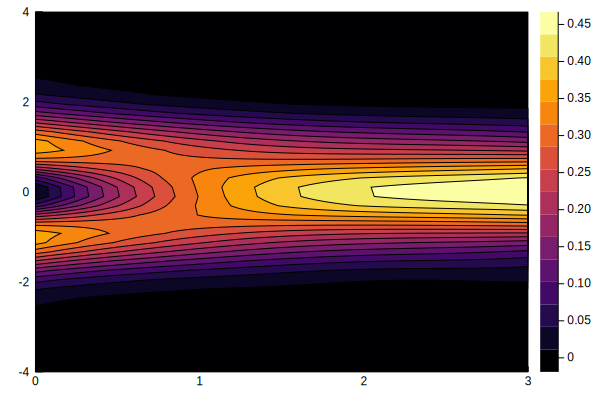

In [12]:
using Plots

p1 = contour(tVec, uVec, f_pred, fill=true)
plot(p1)

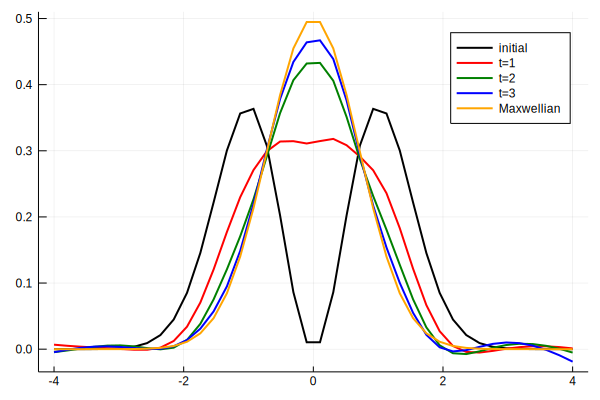

In [13]:
plot(uVec, f_pred[:,1], color="black", width=2, label="initial")
plot!(uVec, f_pred[:,33], color="red", width=2, label="t=1")
plot!(uVec, f_pred[:,66], color="green", width=2, label="t=2")
plot!(uVec, f_pred[:,100], color="blue", width=2, label="t=3")
plot!(uVec, g0, color="orange", width=2, label="Maxwellian")